In [1]:
from oura import OuraClient
import datetime as dt
import json
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# SLEEP DATA

In [2]:
# load data using Python JSON module
with open('./Data/sleep_json','r') as f:
    data = json.loads(f.read())
# Flatten data
df = pd.json_normalize(data, record_path =['sleep'])

In [3]:
df.iloc[0]['bedtime_start']

'2022-08-05T00:41:33+02:00'

In [4]:
sleep_days = df['summary_date'].tolist()

In [5]:
heartrate_lists = []
hrv_list = []
for i in range(0, len(df)):
    
    measures_list = []
    hrv = []
    for measure in range(len(df.iloc[i]['hr_5min'])):
        measures_list.append([df.iloc[i]['hr_5min'][measure]])
        hrv.append(np.abs([df.iloc[i]['rmssd_5min'][measure]]))

    heartrate_lists.append(measures_list)
    hrv_list.append(hrv)


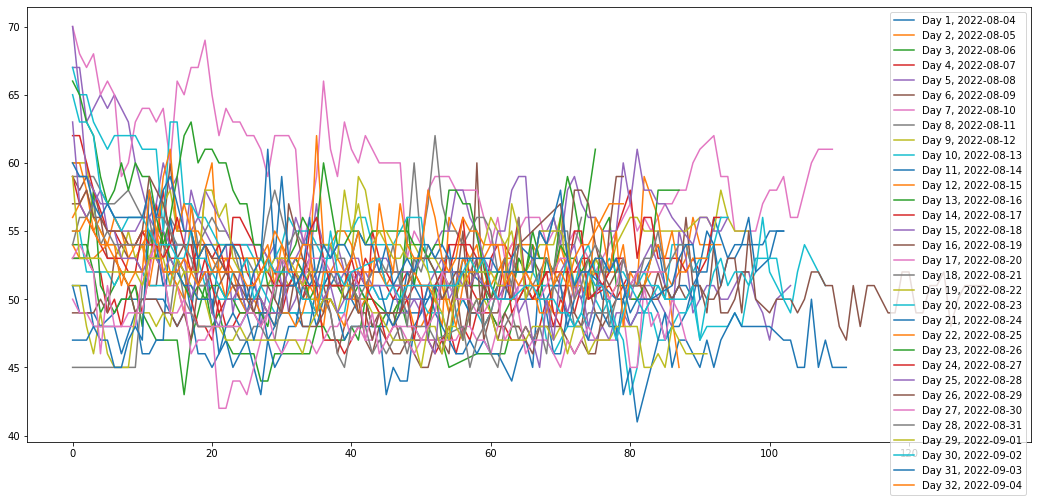

In [6]:
datasets = []
days_idx = []

i = 0
for dataset in heartrate_lists:
    dataset = pd.DataFrame(dataset)
    if(len(dataset) > 60):
        datasets.append(dataset)
        days_idx.append(i)
    i = i + 1
datasets_copy = datasets.copy()
datasets_copy.pop(0)

ax = pd.DataFrame(datasets[0]).plot(figsize=(18,8))
legend_list = ["Day 1, {}".format(sleep_days[0])]

i = 1
for dataset in datasets_copy:
    i = i + 1
    dataset.plot(ax=ax)
    legend_list.append('Day {}, {}'.format(str(i), sleep_days[i-1]))
ax.legend(legend_list);
plt.show()

# Start time series analysis

Source: https://www.kaggle.com/code/izzettunc/introduction-to-time-series-clustering/notebook

In [7]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

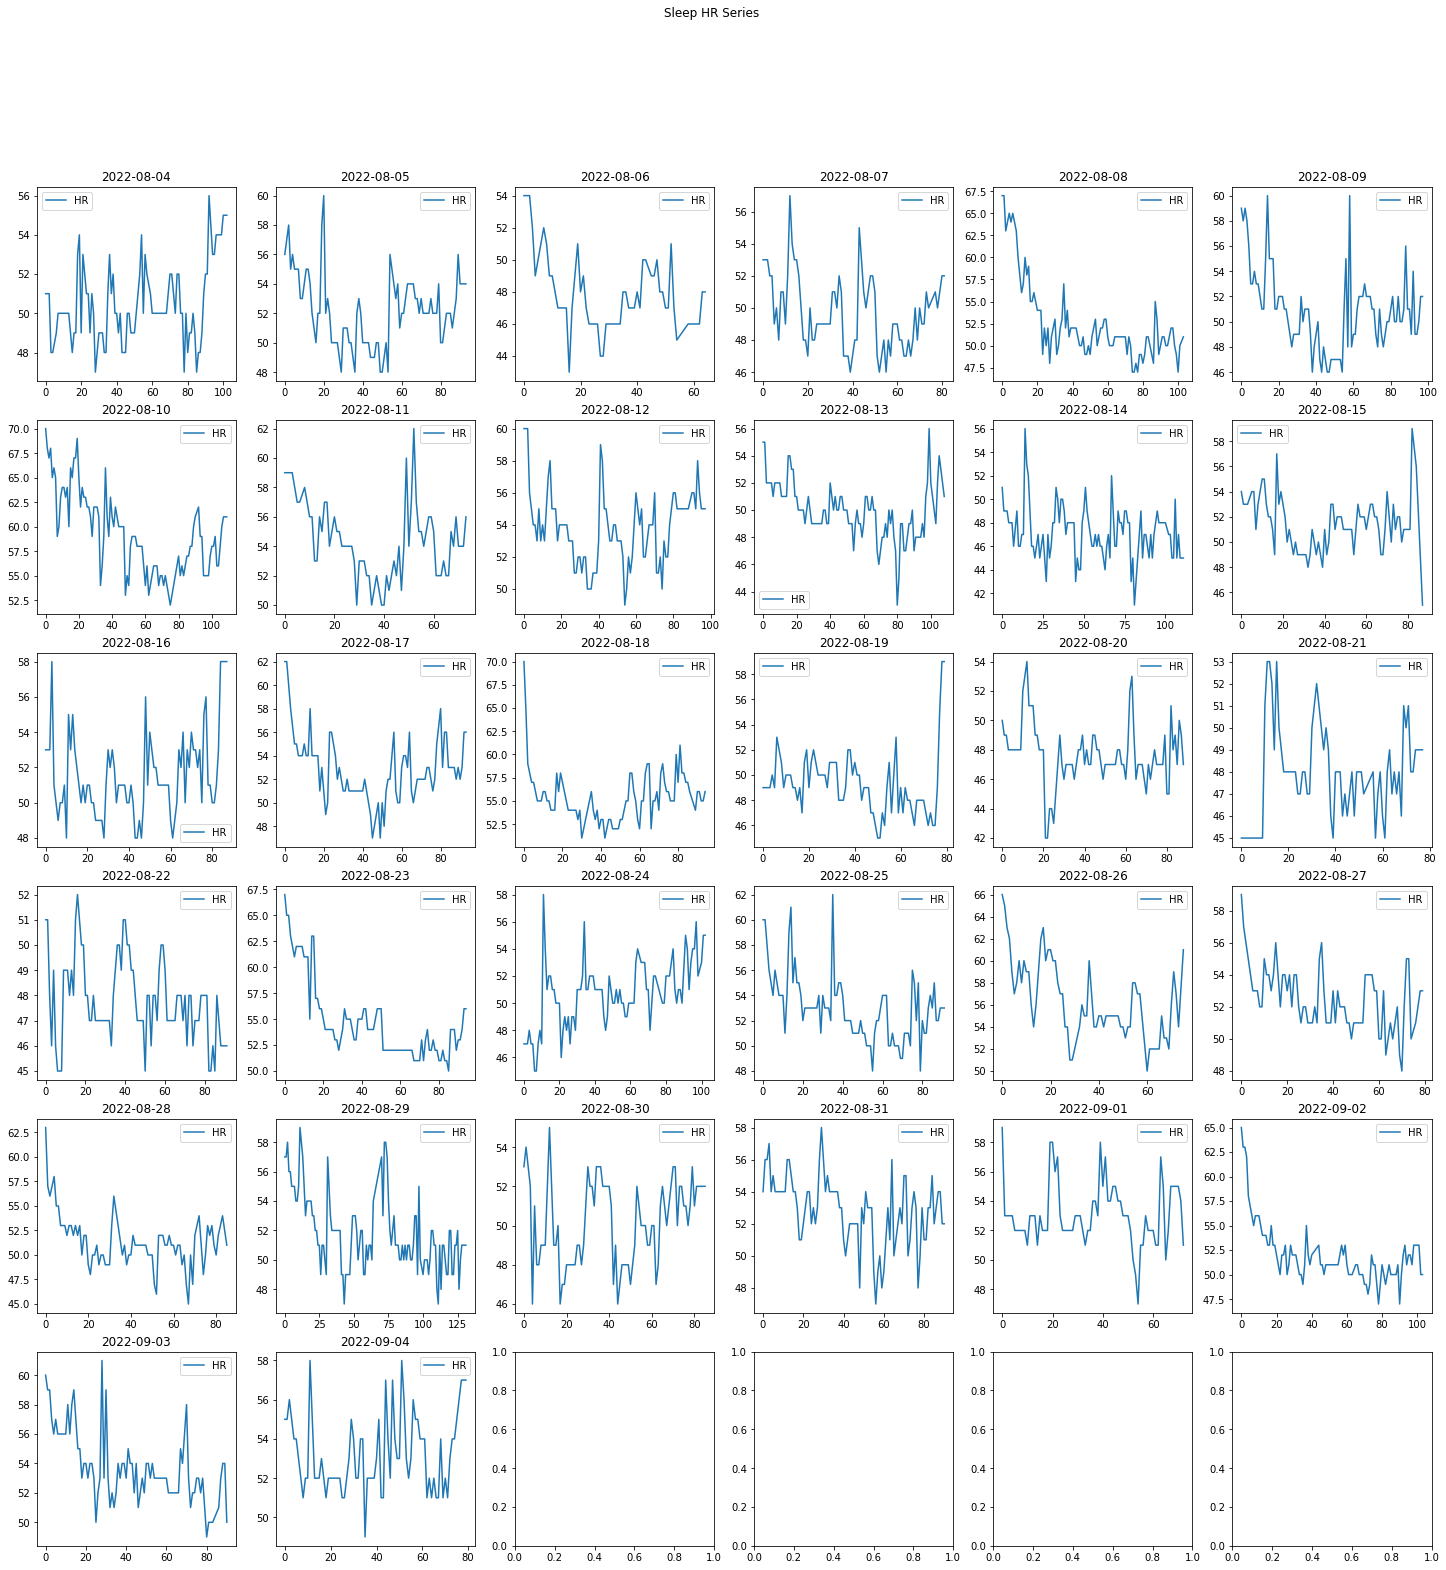

In [8]:
fig, axs = plt.subplots(6,6,figsize=(25,25))
fig.suptitle('Sleep HR Series')
for i in range(6):
    for j in range(6):
        if i*6+j+1>len(datasets): # pass the others that we can't fill
            continue
        datasets[i*6+j].plot(ax=axs[i, j])
        axs[i, j].set_title(sleep_days[i*6+j])
        legend=['HR']
        axs[i, j].legend(legend)
plt.show()

## Preprocessing

Before we start analyzing let's check if our data is uniform in length.

In [9]:
series_lengths = {len(series) for series in datasets}
print(series_lengths)

{132, 65, 73, 74, 76, 78, 80, 82, 86, 88, 89, 91, 92, 94, 95, 98, 103, 104, 109, 110, 112}


To solve this problem, we should first find the longest series of the series and elongate others according to that. Usually, to do this we should check the oldest and newest date and elongate all series according to these dates. Finding the longest series will be enough for us

In [10]:
min_len = min(series_lengths)
shortest_series = None
for series in datasets:
    if len(series) == min_len:
        shortest_series = series

In this code block, I reindexed the series that are not as long as the longest one and fill the empty dates with np.nan.

In [11]:
problems_index = []

for i in range(len(datasets)):
    if len(datasets[i])!= min_len:
        problems_index.append(i)
        datasets[i] = datasets[i].reindex(shortest_series.index)

We have 16 series that are polluted with nan and we used to have 16 series that are shorter than others, so math checks out.

Note that we normalized each time series by their own values, not the values of other time series.

In [12]:
for i in range(len(datasets)):
    scaler = MinMaxScaler()
    datasets[i] = MinMaxScaler().fit_transform(datasets[i])
    datasets[i]= datasets[i].reshape(len(datasets[i]))

In [13]:
problems_index

[0,
 1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31]

## Clustering

I will be using 2 different methods for clustering these series. The first of the methods is Self Organizing Maps(SOM) and the other method is K-Means

### SOM

Self-organizing maps are a type of neural network that is trained using unsupervised learning to produce a low-dimensional representation of the input space of the training samples, called a map.

![image.png](https://raw.githubusercontent.com/izzettunc/Kohonen-SOM/master/data/screenshots/landing.png)

Also, self-organizing maps differ from other artificial neural networks as they apply competitive(or cooperative) learning as opposed to error-correction learning (such as backpropagation with gradient descent), and in the sense that they use a neighborhood function to preserve the topological properties of the input space.

![image.png](https://upload.wikimedia.org/wikipedia/commons/3/35/TrainSOM.gif)

For the implementation of the som algorithm I used miniSom and set my parameters as follows:
<ul>
<li>sigma: 0.3</li>
<li>learning_rate: 0.5</li>
<li>random weight initialization</li>
<li>50.000 iteration</li>
<li>Map size: square root of the number of series</li>
</ul>
As a side note, I didn't optimize these parameters due to the simplicity of the dataset.

In [14]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(datasets))))

som = MiniSom(som_x, som_y,len(datasets[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(datasets)
som.train(datasets, 50000)

#### Results

After the training, I plotted the results. For each cluster, I plotted every series, a little bit transparent and in gray, and in order to see the movement or the shape of the cluster, I took the average of the cluster and plotted that averaged series in red

In [15]:
# Little handy function to plot series

def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

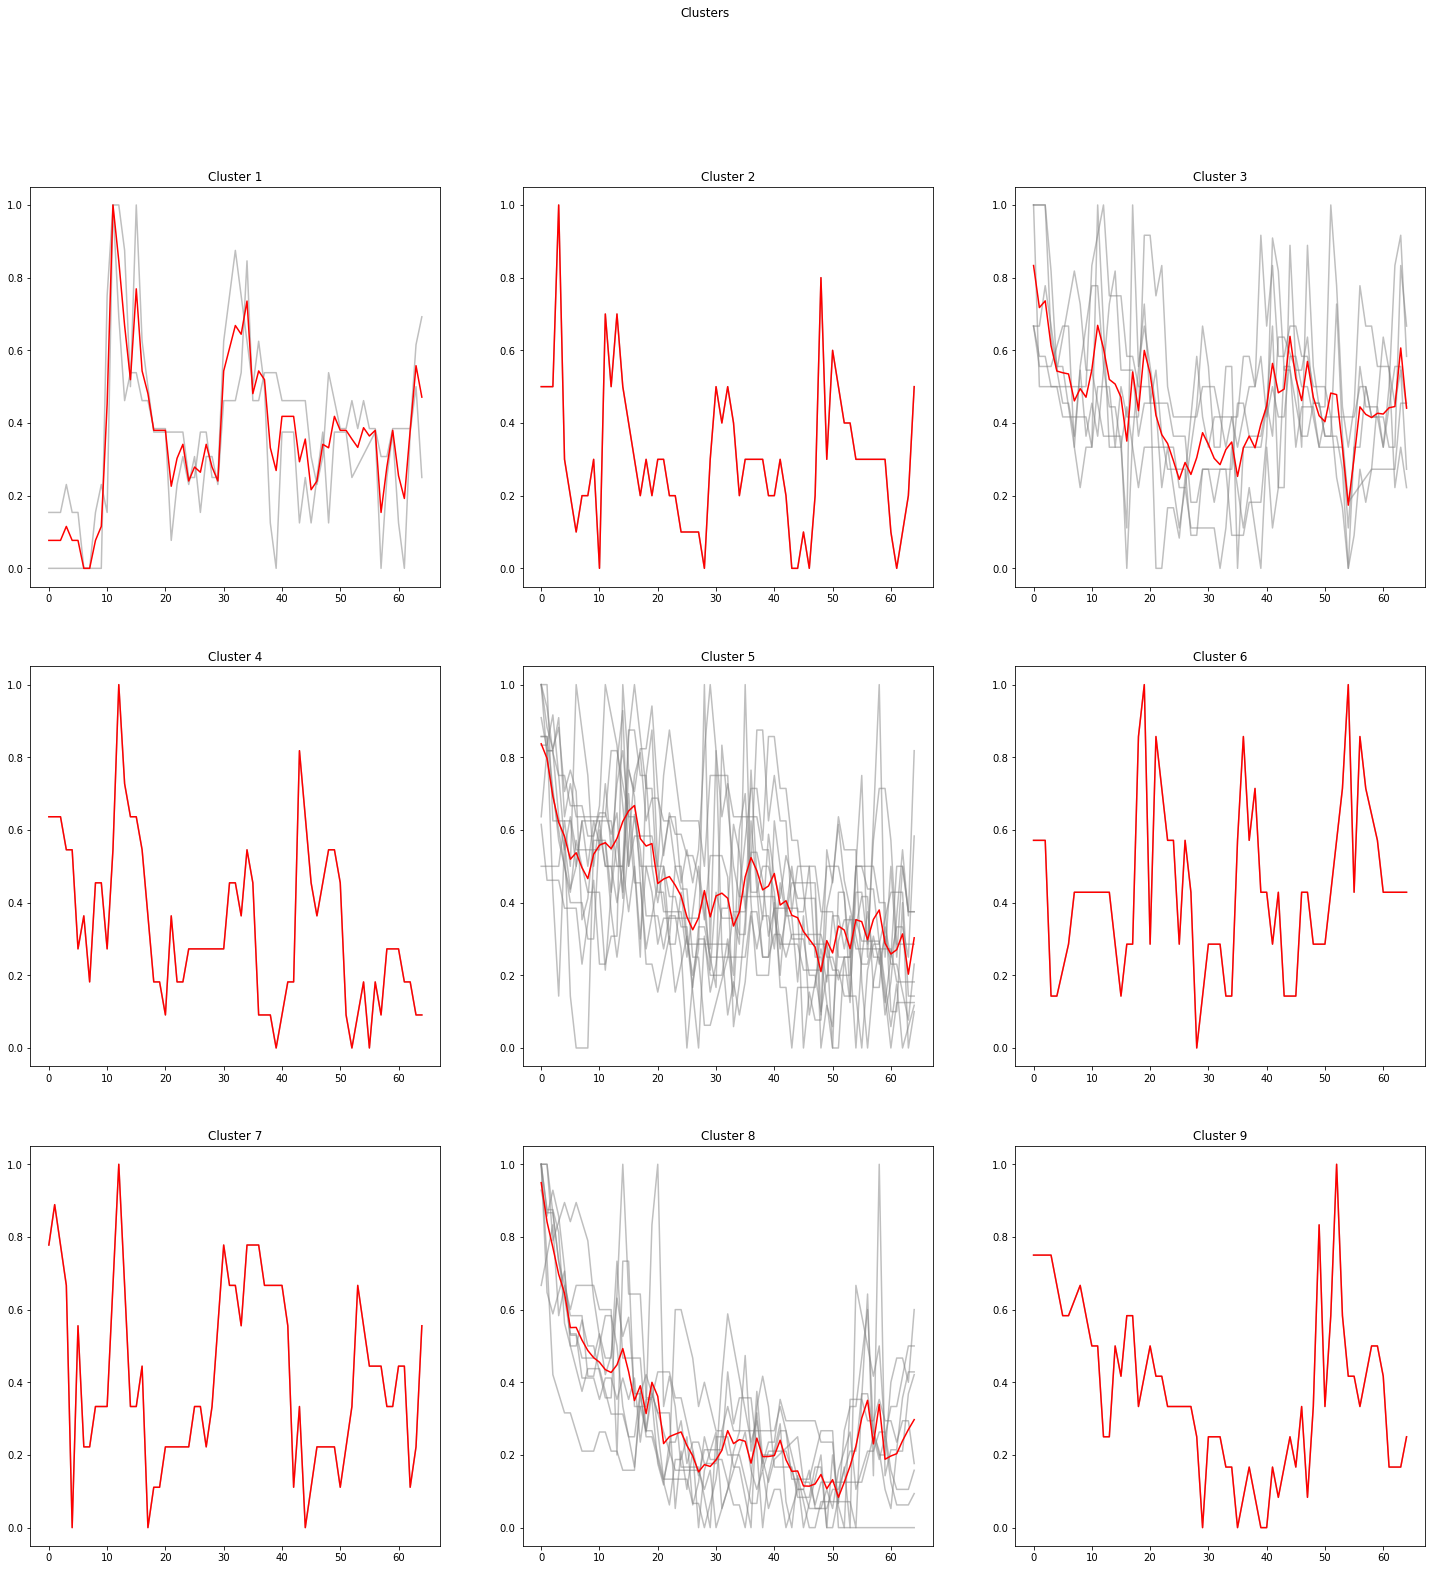

In [16]:
win_map = som.win_map(datasets)
# Returns the mapping of the winner nodes and inputs

plot_som_series_averaged_center(som_x, som_y, win_map)

Another method to extract the movement/shape of the cluster is instead of averaging each series in the cluster, using Dynamic Time Warping Barycenter Averaging (DBA).

DBA is another type of averaging method that used the Dynamic Time Warping method in it and might be very useful to extract the movement/shape of the cluster as seen in the following images.

![image.png](https://raw.githubusercontent.com/fpetitjean/DBA/master/images/arithmetic.png)
![image.png](https://raw.githubusercontent.com/fpetitjean/DBA/master/images/DBA.png)

To do so, I used dtw_barycenter_averaging method in the tslearn library and changed the np.average with it.

In [17]:
def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red") # I changed this part
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

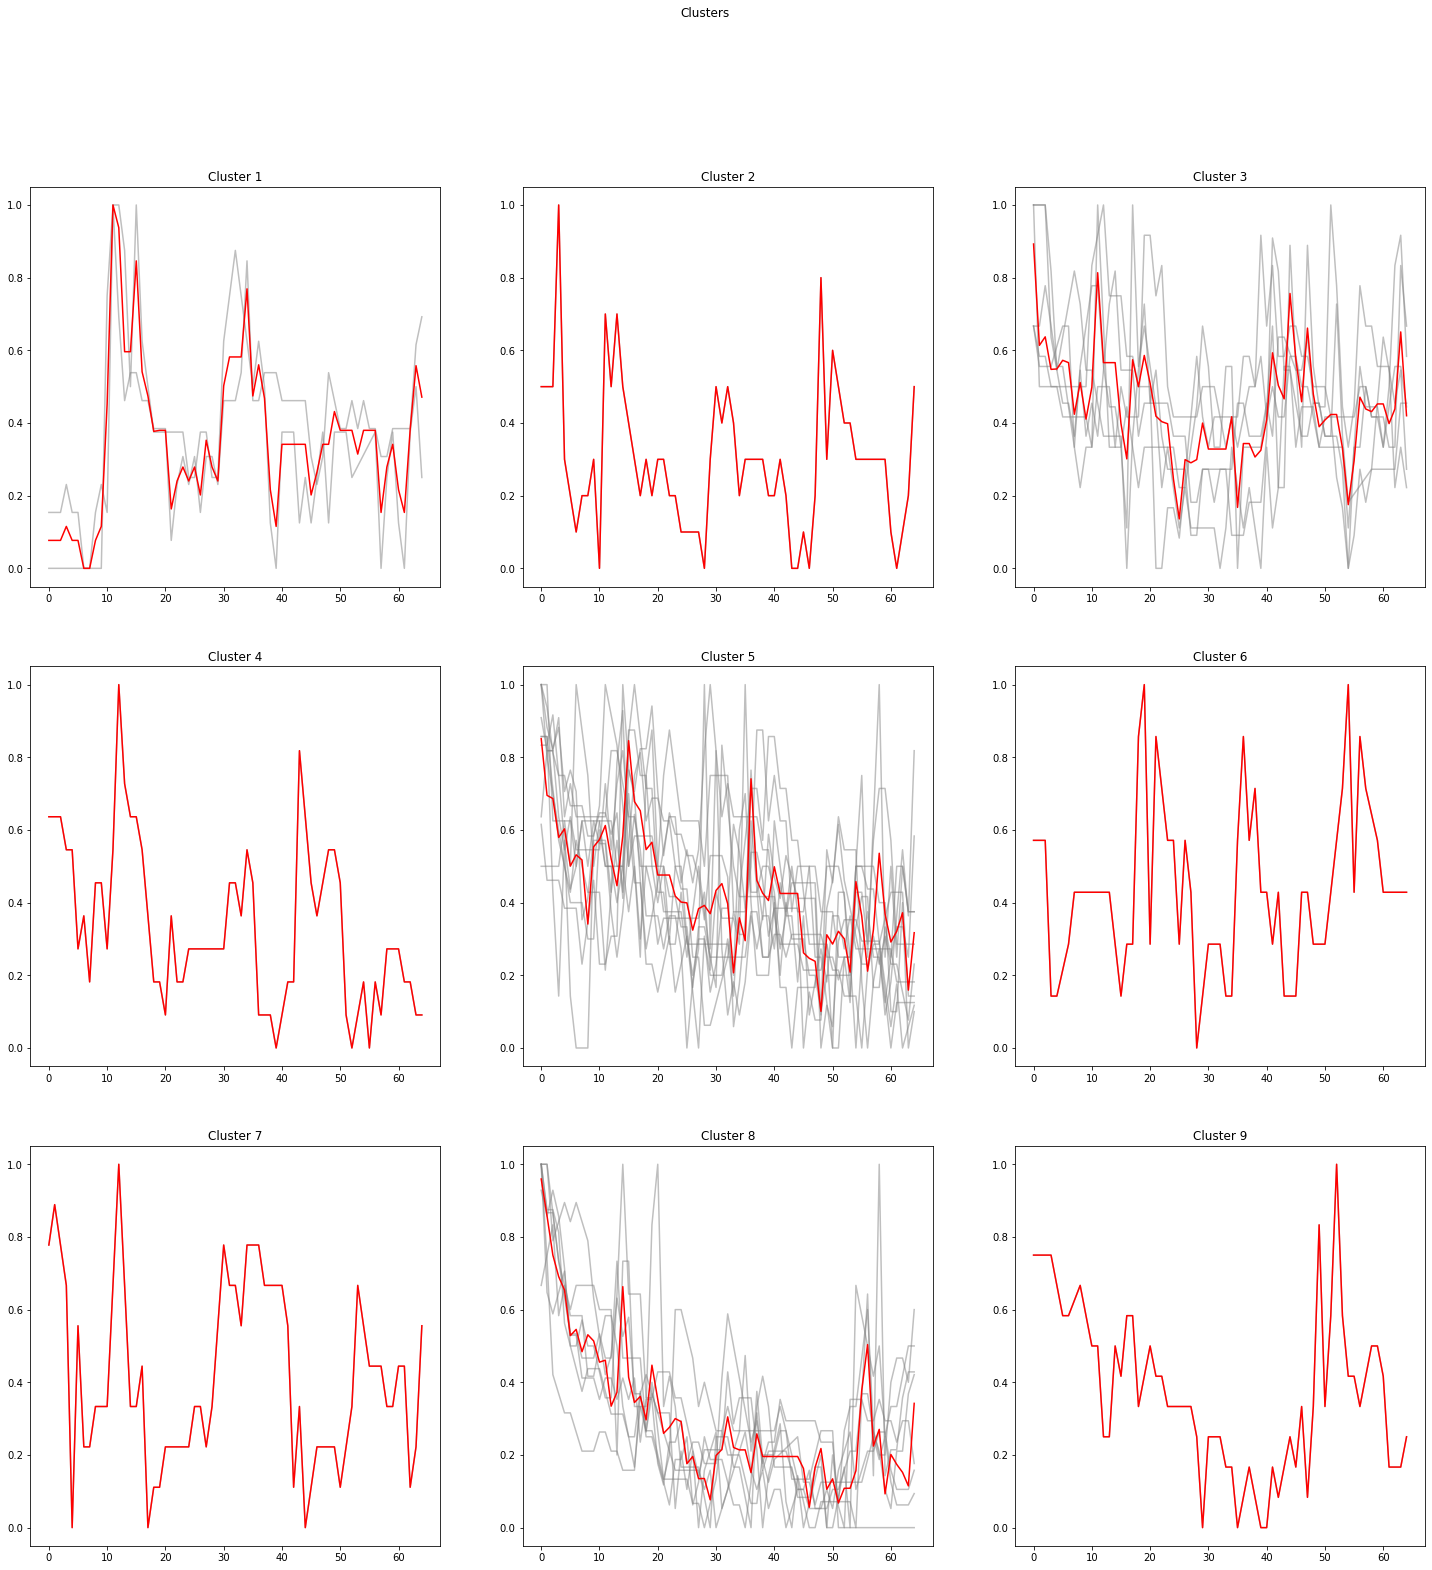

In [18]:
win_map = som.win_map(datasets)

plot_som_series_dba_center(som_x, som_y, win_map)

#### Cluster Distribution

We can see the distribution of the time series in clusters in the following chart.

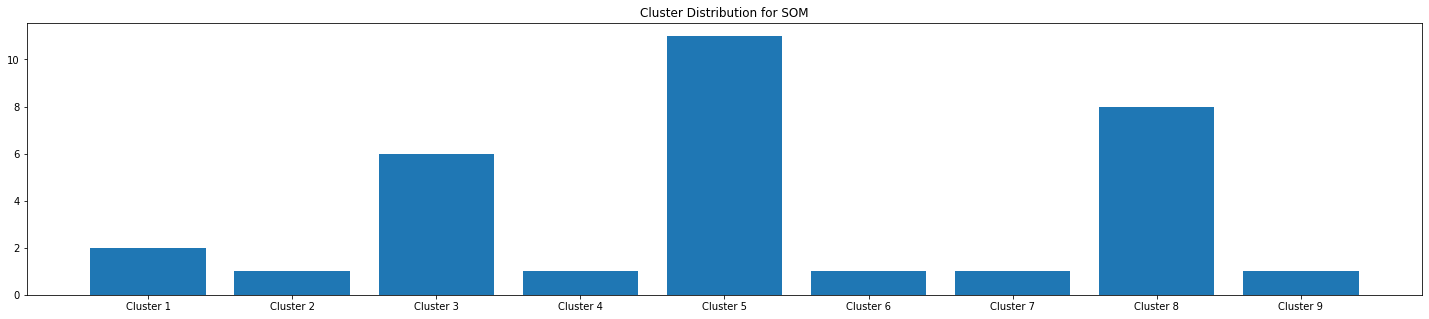

In [19]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

#### Cluster Mapping

Well, we did cluster our series but how de we know which series belonging to which cluster? Ain't that the whole purpose of clustering?

As we can see in these illustrations each node (or multiple of nodes in some cases) represents a cluster. Therefore we can find out which series is belonging to which cluster by checking the winner node of each series.

In [20]:
for dataset in datasets:
    print(som.winner(dataset))

(1, 2)
(2, 1)
(0, 2)
(1, 0)
(2, 1)
(2, 1)
(1, 1)
(2, 2)
(0, 2)
(1, 1)
(1, 1)
(0, 2)
(0, 1)
(2, 1)
(2, 1)
(1, 1)
(0, 2)
(0, 0)
(1, 1)
(2, 1)
(0, 0)
(1, 1)
(1, 1)
(1, 1)
(2, 1)
(1, 1)
(2, 0)
(1, 1)
(0, 2)
(2, 1)
(1, 1)
(0, 2)


In order to make this piece of information more appealing to eye, we can map each node to a number
and print the name of the series with the cluster number

In [21]:
cluster_map = []
for idx in range(len(datasets)):
    winner_node = som.winner(datasets[idx])
    cluster_map.append((sleep_days[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Series").set_index("Series")

Cluster
Series               
2022-08-04  Cluster 6
2022-08-05  Cluster 8
2022-08-06  Cluster 3
2022-08-07  Cluster 4
2022-08-08  Cluster 8
2022-08-09  Cluster 8
2022-08-10  Cluster 5
2022-08-11  Cluster 9
2022-08-12  Cluster 3
2022-08-13  Cluster 5
2022-08-14  Cluster 5
2022-08-15  Cluster 3
2022-08-16  Cluster 2
2022-08-17  Cluster 8
2022-08-18  Cluster 8
2022-08-19  Cluster 5
2022-08-20  Cluster 3
2022-08-21  Cluster 1
2022-08-22  Cluster 5
2022-08-23  Cluster 8
2022-08-24  Cluster 1
2022-08-25  Cluster 5
2022-08-26  Cluster 5
2022-08-27  Cluster 5
2022-08-28  Cluster 8
2022-08-29  Cluster 5
2022-08-30  Cluster 7
2022-08-31  Cluster 5
2022-09-01  Cluster 3
2022-09-02  Cluster 8
2022-09-03  Cluster 5
2022-09-04  Cluster 3

### K-Means

K-means clustering is a method that aims to cluster n input to k clusters in which each data point belongs to cluster with the nearest mean (cluster centroid). It can be visualized as Voronoi cells and it is one of the most popular clustering algorithms and the most basic one

![image.png](https://i.imgur.com/k4XcapI.gif)

In order to cluster our series with k-means, the essential thing to do is, as we do it with som, removing our time indices from our time series, and instead of measured values of each date, we should accept them as different features and dimensions of a single data point. Another important thing to do is, selecting the distance metric. In the k-means algorithm, people usually use the euclidean distance but as we've seen in DBA, it is not effective in our case. So, we will be using Dynamic Time Warping (DTW) instead of euclidean distance and you can see why we are doing this in the following images.

![image.png](https://upload.wikimedia.org/wikipedia/commons/6/69/Euclidean_vs_DTW.jpg)

In [22]:
#cluster_count = math.ceil(math.sqrt(len(datasets))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

#But i want to cluster in 2 clusters 
cluster_count = 3
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(datasets)

#### Results

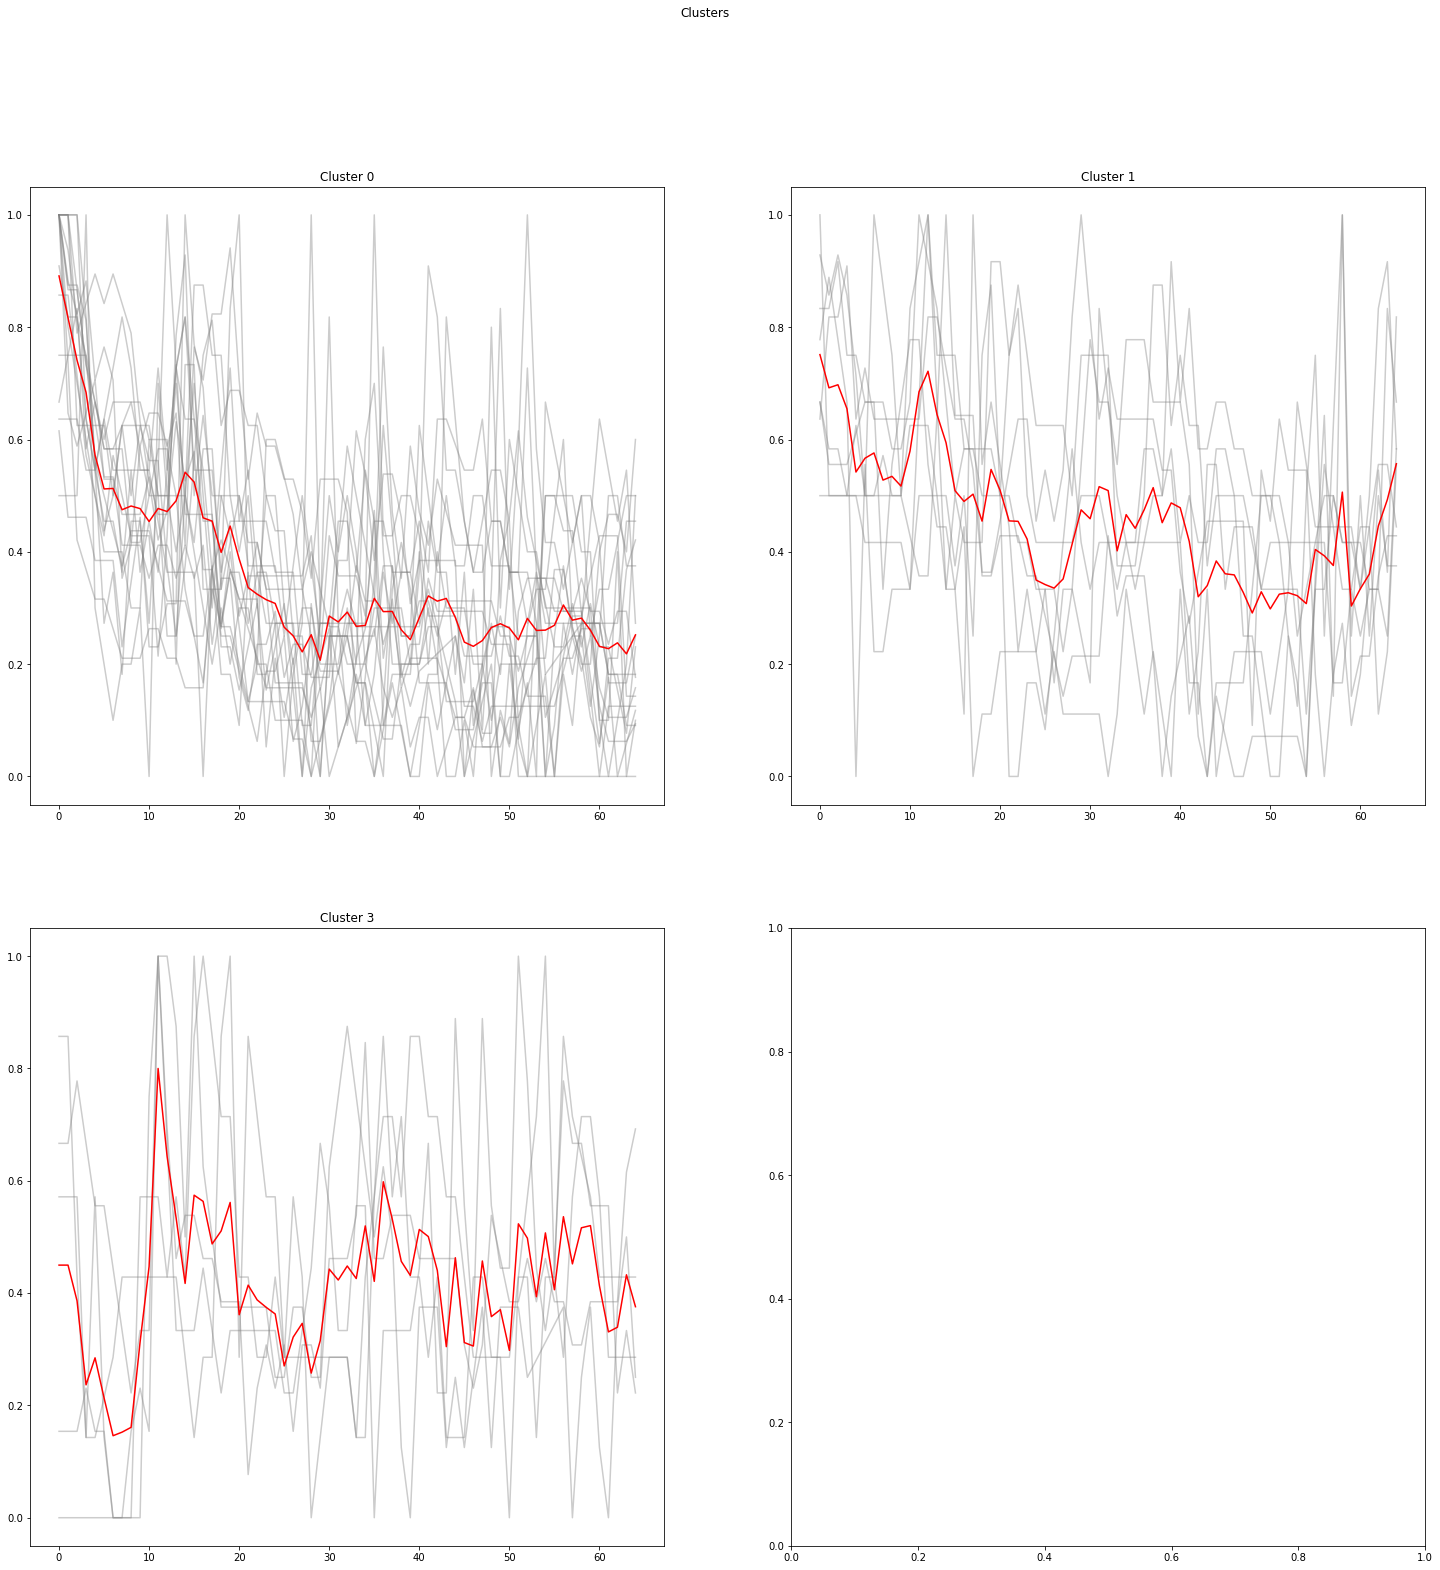

In [23]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(datasets[i],c="gray",alpha=0.4)
                cluster.append(datasets[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

As I did before, I used DBA to see much more time dilated series.

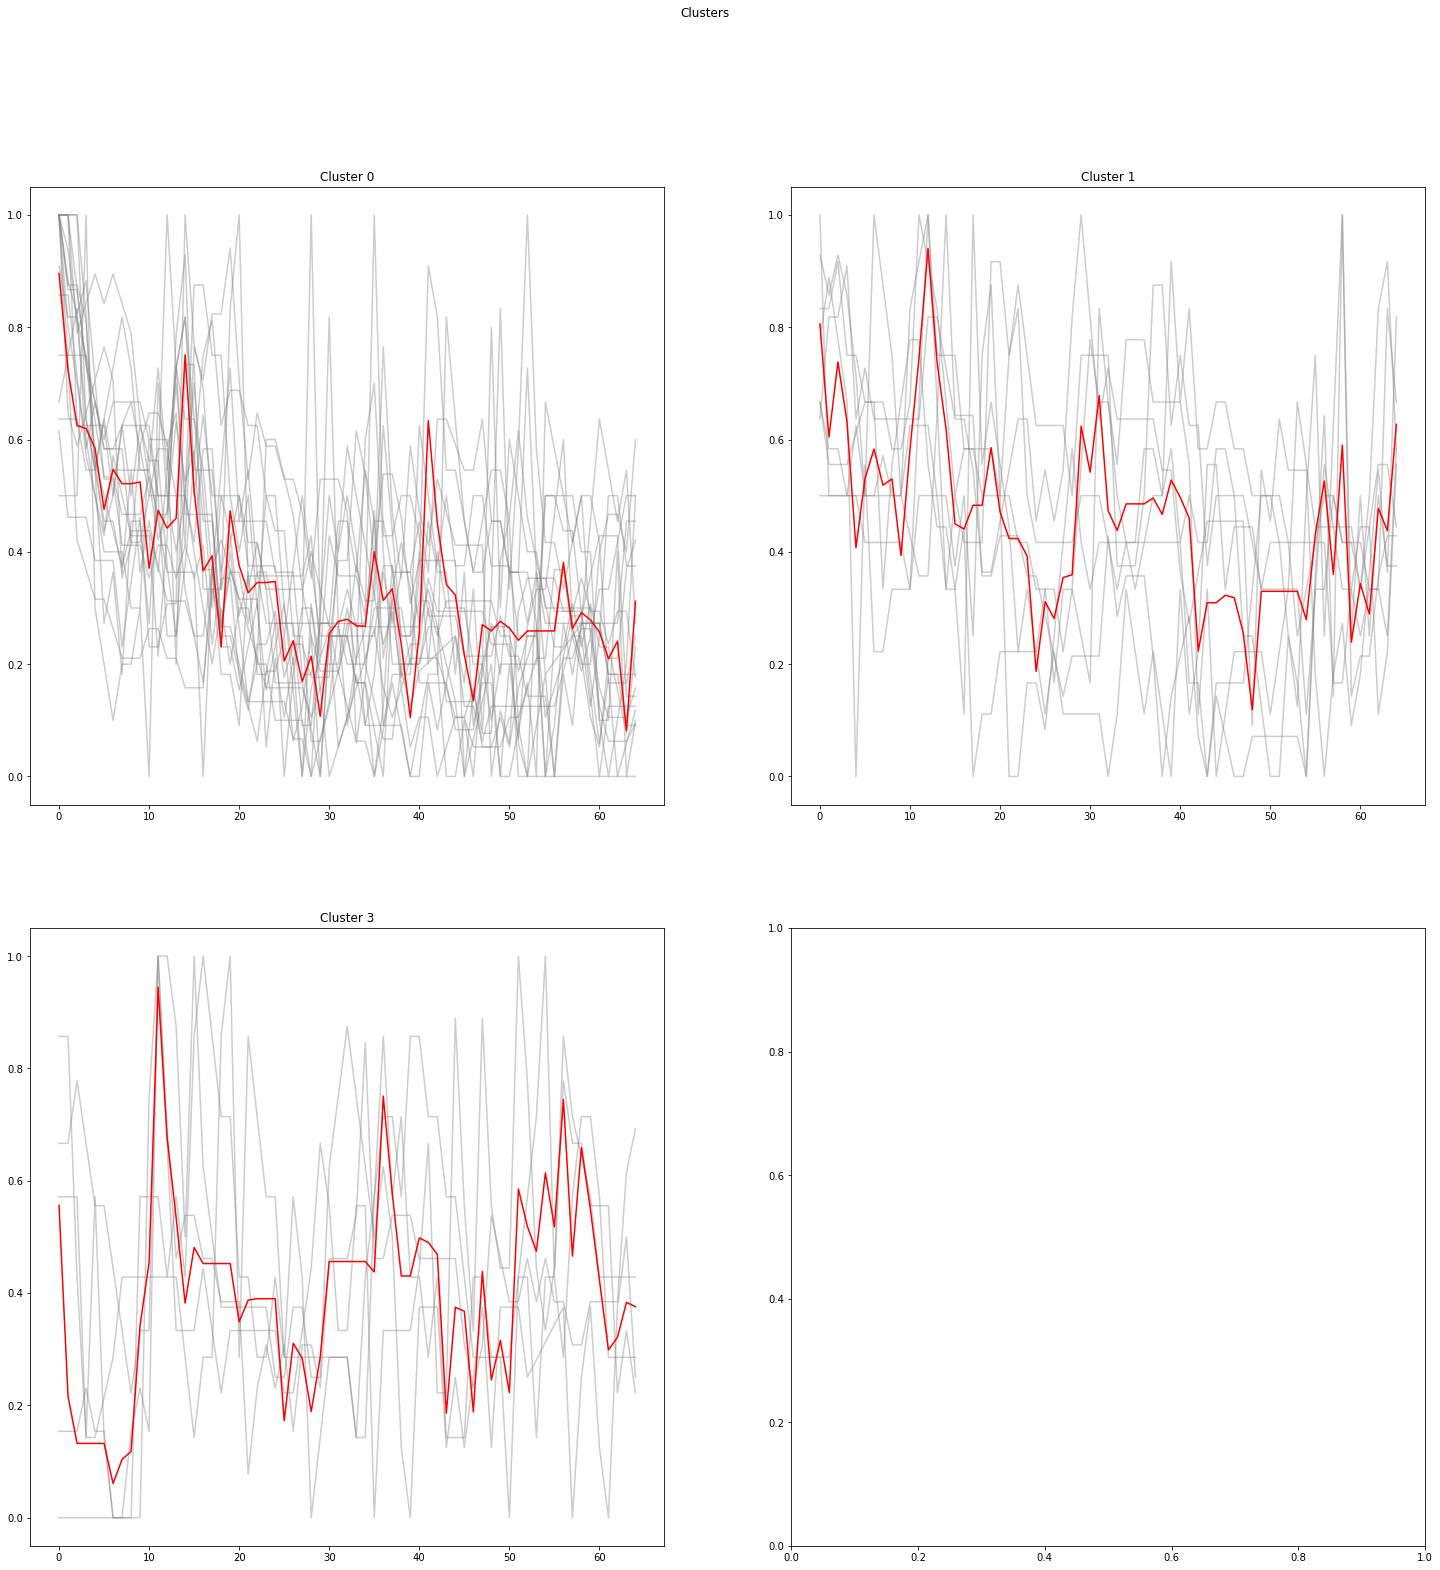

In [24]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(datasets[i],c="gray",alpha=0.4)
                cluster.append(datasets[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

#### Cluster Distribution

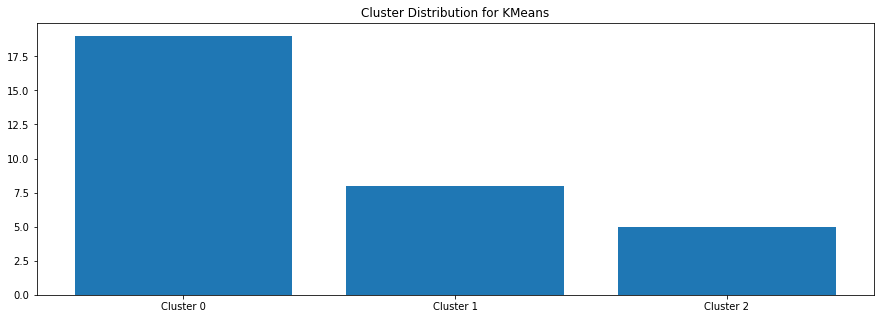

In [25]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["Cluster "+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

#### Cluster Mapping

As we did before, in this part we will be finding which series belonging to which cluster. Thanks to awesome scikit-learn library we actually already have that information. Order of the labels is the same order with our series

In [26]:
labels

array([2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 2, 2, 0, 2, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 2], dtype=int64)

In [27]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
pd.DataFrame(zip(sleep_days,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Series").set_index("Series")

Cluster
Series               
2022-08-04  Cluster 2
2022-08-05  Cluster 0
2022-08-06  Cluster 0
2022-08-07  Cluster 0
2022-08-08  Cluster 0
2022-08-09  Cluster 1
2022-08-10  Cluster 0
2022-08-11  Cluster 0
2022-08-12  Cluster 0
2022-08-13  Cluster 0
2022-08-14  Cluster 0
2022-08-15  Cluster 1
2022-08-16  Cluster 0
2022-08-17  Cluster 0
2022-08-18  Cluster 0
2022-08-19  Cluster 1
2022-08-20  Cluster 1
2022-08-21  Cluster 2
2022-08-22  Cluster 2
2022-08-23  Cluster 0
2022-08-24  Cluster 2
2022-08-25  Cluster 0
2022-08-26  Cluster 0
2022-08-27  Cluster 0
2022-08-28  Cluster 0
2022-08-29  Cluster 1
2022-08-30  Cluster 1
2022-08-31  Cluster 1
2022-09-01  Cluster 1
2022-09-02  Cluster 0
2022-09-03  Cluster 0
2022-09-04  Cluster 2

#### Curse of Dimensionality

Curse of Dimensionality is a term, first invented by Richard E. Bellman when considering problems in dynamic programming. It basically means, when the dimensionality of the data increase so does the distance between data points. Thus, this change in measurement of distance affects the distance-based algorithms badly. To learn for more about it please check section 5. See Also.

To solve this problem there are numerous algorithms that can be helpful such as PCA which is the most prominent of them, t-SNE, UMAP(map of the som), etc.

In [28]:
pca = PCA(n_components=2)

mySeries_transformed = pca.fit_transform(datasets)

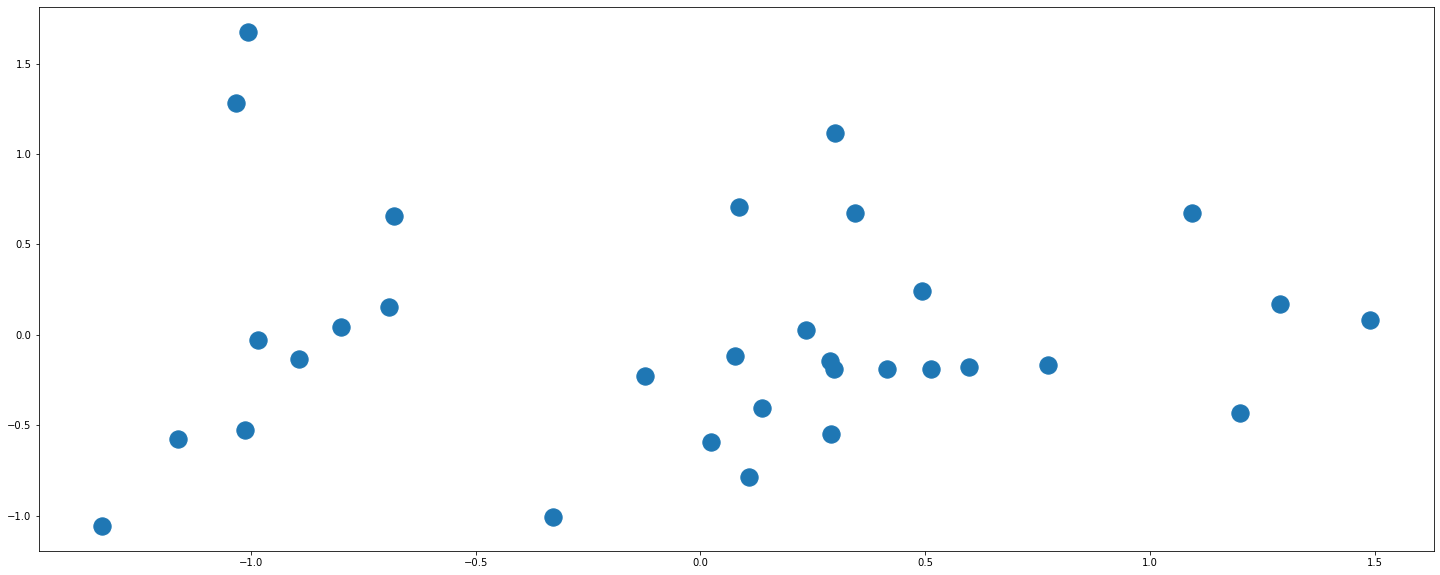

In [29]:
plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:,0],mySeries_transformed[:,1], s=300)
plt.show()

The result of PCA is basically, representation of a 100-dimensional data point as a 2-dimensional data point. As a result of that instead of a time series, we have just 2 value for each series.

In [30]:
print(mySeries_transformed)

[[-0.89373452 -0.13335211]
 [ 0.51310459 -0.1887342 ]
 [ 0.1089388  -0.78459486]
 [ 0.34287724  0.67385385]
 [ 1.1988816  -0.43058276]
 [ 0.77365214 -0.1672209 ]
 [-0.32740051 -1.00608881]
 [ 0.5960949  -0.18079781]
 [ 0.13737573 -0.40313104]
 [ 0.02328239 -0.59542788]
 [ 0.08624659  0.70852802]
 [ 0.29675728 -0.19046675]
 [ 0.29923925  1.1167912 ]
 [ 0.41545287 -0.19058116]
 [ 1.09265426  0.67313867]
 [-1.33077377 -1.05843339]
 [-0.79959064  0.04040244]
 [-1.00583905  1.67503969]
 [-0.98460327 -0.02899272]
 [ 1.48921437  0.08341576]
 [-1.03280605  1.28399591]
 [ 0.07637166 -0.11510676]
 [ 0.2909771  -0.54855882]
 [ 0.23459195  0.02477138]
 [ 0.49229206  0.24081134]
 [-0.12349706 -0.2277184 ]
 [-0.6815346   0.65504559]
 [-1.01211555 -0.52807169]
 [-1.161679   -0.57576324]
 [ 1.28948551  0.17122085]
 [ 0.28889762 -0.14774161]
 [-0.69281388  0.15435024]]


Thus, we don't have to use dtw anymore and instead of TimeSeriesKMeans from tslearn, we can use basic KMeans from sklearn.

In [31]:
kmeans = KMeans(n_clusters=cluster_count,max_iter=5000)

labels = kmeans.fit_predict(mySeries_transformed)

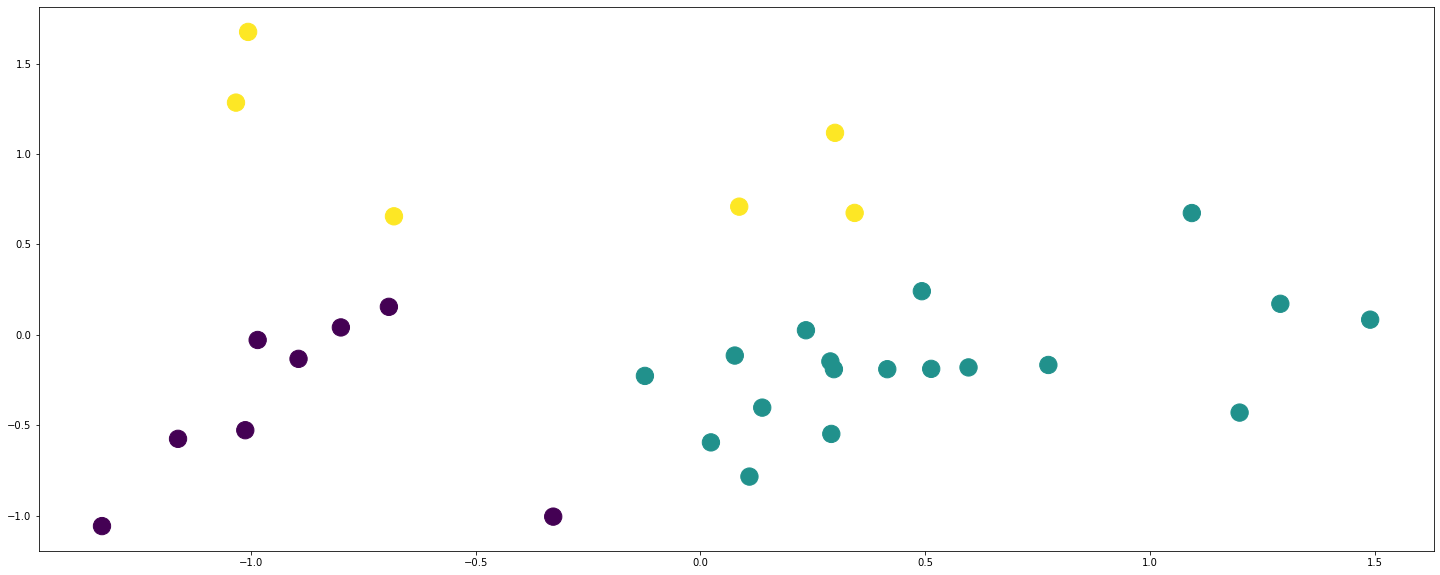

In [32]:
plt.figure(figsize=(25,10))
plt.scatter(mySeries_transformed[:, 0], mySeries_transformed[:, 1], c=labels, s=300)
plt.show()

And again thanks to the clever implementation of KMeans algorithm by sklearn team, labels are returned in the same order. Thus, we can use the same code to visualize our cluster in series.

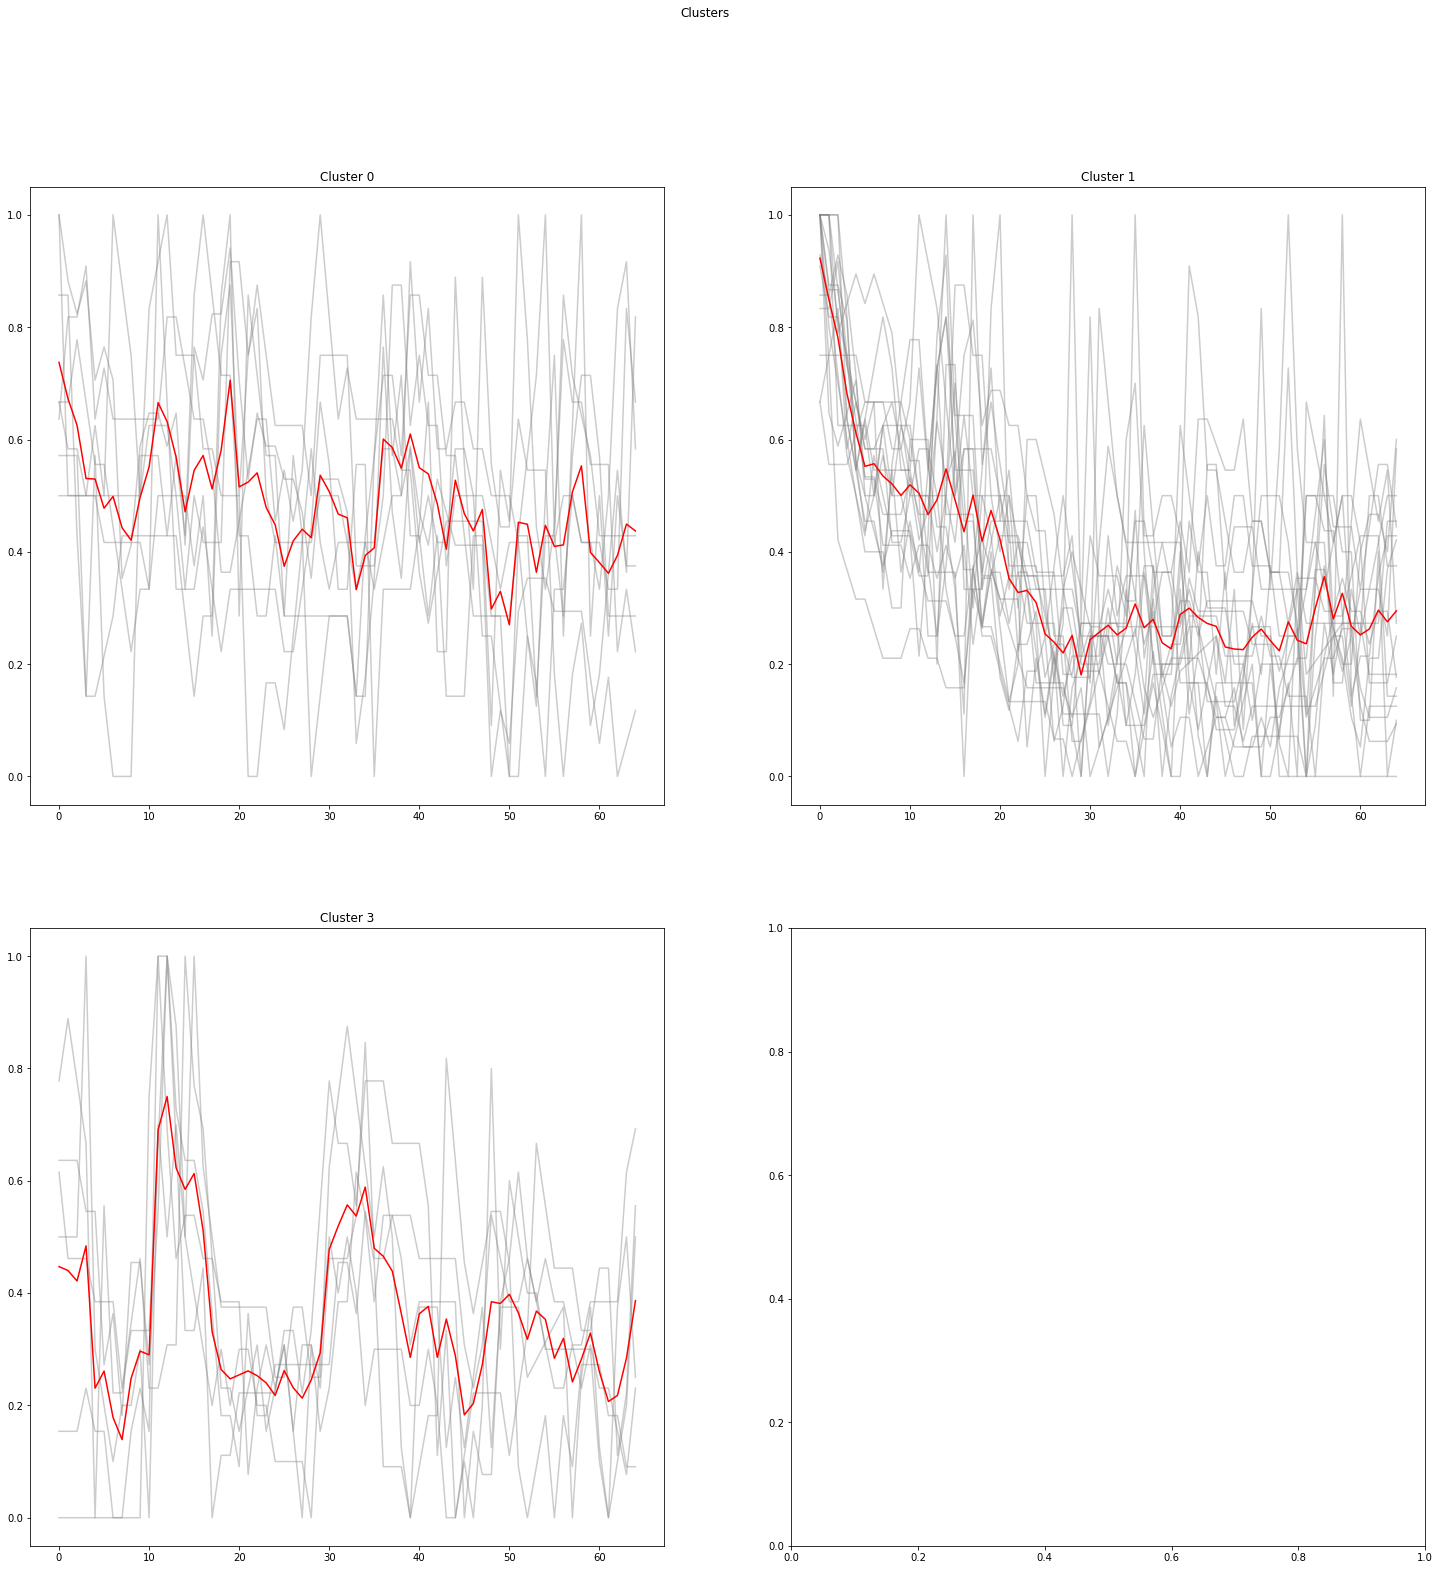

In [33]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(datasets[i],c="gray",alpha=0.4)
                cluster.append(datasets[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

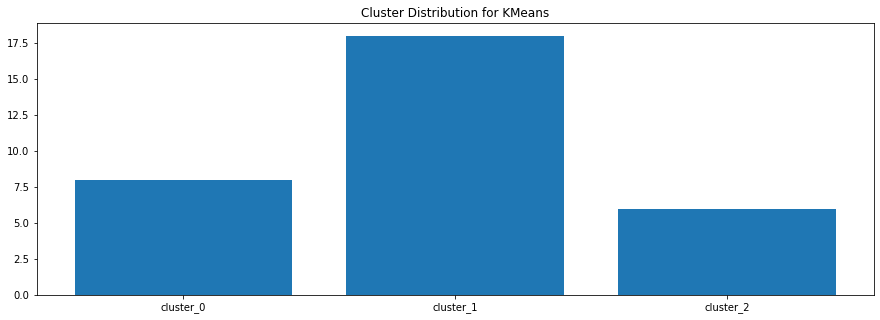

In [34]:
cluster_c = [len(labels[labels==i]) for i in range(cluster_count)]
cluster_n = ["cluster_"+str(i) for i in range(cluster_count)]
plt.figure(figsize=(15,5))
plt.title("Cluster Distribution for KMeans")
plt.bar(cluster_n,cluster_c)
plt.show()

In [35]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
pd.DataFrame(zip(sleep_days,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Series").set_index("Series")

Cluster
Series               
2022-08-04  Cluster 0
2022-08-05  Cluster 1
2022-08-06  Cluster 1
2022-08-07  Cluster 2
2022-08-08  Cluster 1
2022-08-09  Cluster 1
2022-08-10  Cluster 0
2022-08-11  Cluster 1
2022-08-12  Cluster 1
2022-08-13  Cluster 1
2022-08-14  Cluster 2
2022-08-15  Cluster 1
2022-08-16  Cluster 2
2022-08-17  Cluster 1
2022-08-18  Cluster 1
2022-08-19  Cluster 0
2022-08-20  Cluster 0
2022-08-21  Cluster 2
2022-08-22  Cluster 0
2022-08-23  Cluster 1
2022-08-24  Cluster 2
2022-08-25  Cluster 1
2022-08-26  Cluster 1
2022-08-27  Cluster 1
2022-08-28  Cluster 1
2022-08-29  Cluster 1
2022-08-30  Cluster 2
2022-08-31  Cluster 0
2022-09-01  Cluster 0
2022-09-02  Cluster 1
2022-09-03  Cluster 1
2022-09-04  Cluster 0

In [36]:
from tslearn.clustering import silhouette_score
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 8]

from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import pandas as pd

In [37]:
datasets = []

for dataset in heartrate_lists:
    dataset = pd.DataFrame(dataset)
    if(len(dataset) > 60):
        datasets.append(dataset)


series_lengths = {len(series) for series in datasets}
min_len = min(series_lengths)
shortest_series = None
for series in datasets:
    if len(series) == min_len:
        shortest_series = series
        
problems_index = []

for i in range(len(datasets)):
    if len(datasets[i])!= min_len:
        problems_index.append(i)
        datasets[i] = datasets[i].reindex(shortest_series.index)
        
datasets_input = np.zeros(shape=(len(datasets), min_len,1))
i = 0
for dataset in datasets:
    dataset = pd.DataFrame(dataset)
    if(len(dataset) > 60):
        datasets_input[i] = np.array(dataset[0]).reshape(-1,1)
    i = i+1

In [38]:
datasets_hrv = []

for dataset in hrv_list:
    dataset = pd.DataFrame(dataset)
    if(len(dataset) > 60):
        datasets_hrv.append(dataset)


series_lengths = {len(series) for series in datasets_hrv}
min_len = min(series_lengths)
shortest_series = None
for series in datasets_hrv:
    if len(series) == min_len:
        shortest_series = series
        
problems_index = []

for i in range(len(datasets_hrv)):
    if len(datasets_hrv[i])!= min_len:
        problems_index.append(i)
        datasets_hrv[i] = datasets_hrv[i].reindex(shortest_series.index)
        
datasets_input_hrv = np.zeros(shape=(len(datasets_hrv), min_len,1))
i = 0
for dataset in datasets_hrv:
    dataset = pd.DataFrame(dataset)
    if(len(dataset) > 60):
        datasets_input_hrv[i] = np.array(dataset[0]).reshape(-1,1)
    i = i+1

In [39]:
print(len(datasets), len(datasets_hrv))

32 32


In [40]:
seed = 0
np.random.seed(seed)
X_train = TimeSeriesScalerMeanVariance().fit_transform(datasets_input)
sz = X_train.shape[1]

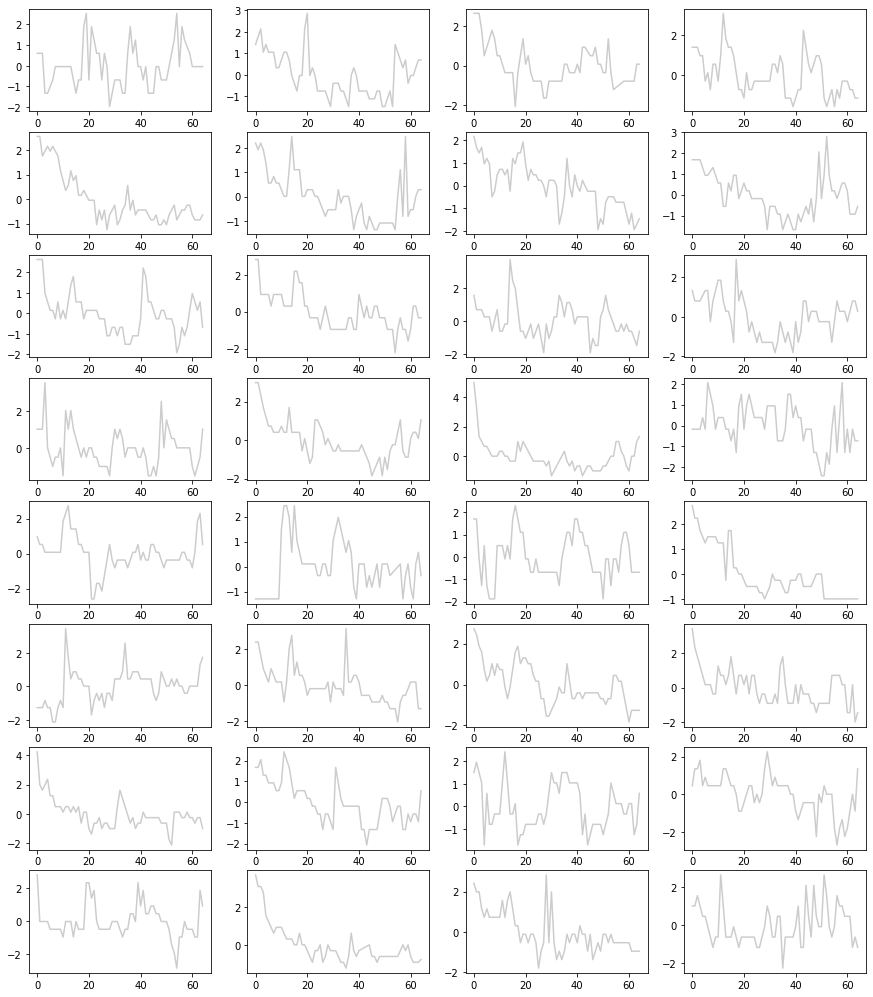

In [41]:
plt.figure(figsize=(15,20))
for yi in range(len(datasets_input)):
    plt.subplot( (np.floor(len(datasets_input)/4) + 1),4, yi + 1)
    plt.plot(X_train[yi].ravel(), "k-", alpha=.2)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

In [42]:
seed = 0
np.random.seed(seed)
X_train_hrv = TimeSeriesScalerMeanVariance().fit_transform(datasets_input_hrv)
sz = X_train_hrv.shape[1]

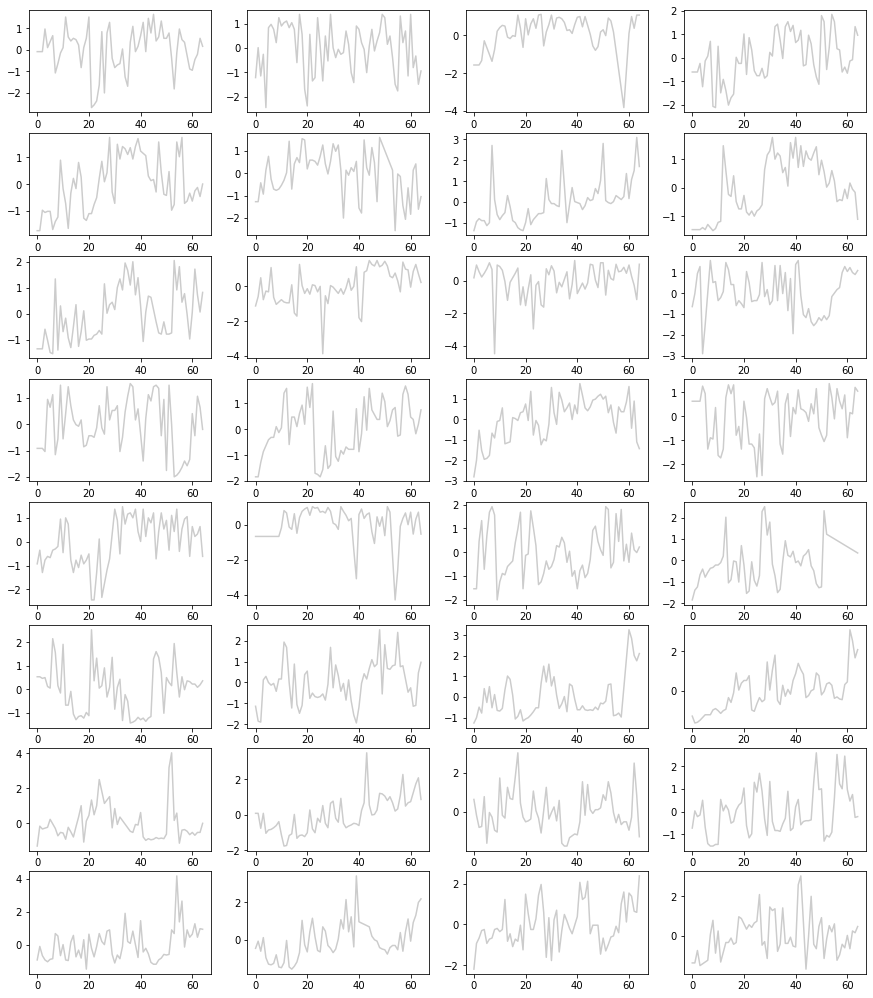

In [43]:
plt.figure(figsize=(15,20))
for yi in range(len(datasets_input_hrv)):
    plt.subplot( (np.floor(len(datasets_input_hrv)/4) + 1),4, yi + 1)
    plt.plot(X_train_hrv[yi].ravel(), "k-", alpha=.2)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

In [44]:
Sum_of_squared_distances = []
K = range(2,15)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)
    
    km = km.fit(X_train)
    Sum_of_squared_distances.append(km.inertia_)

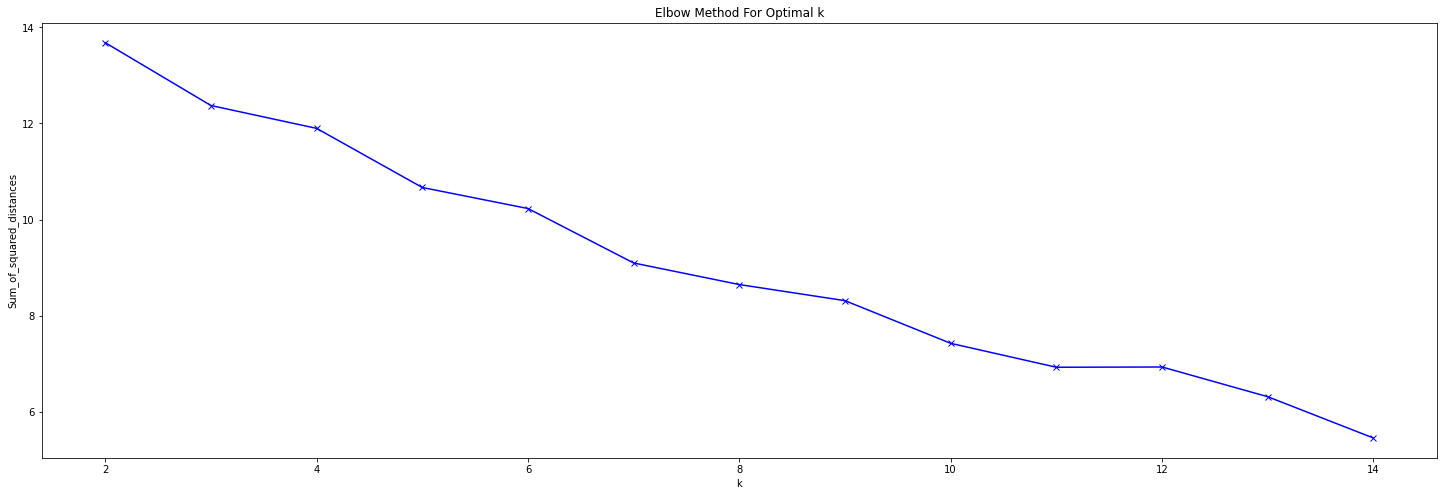

In [45]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.32


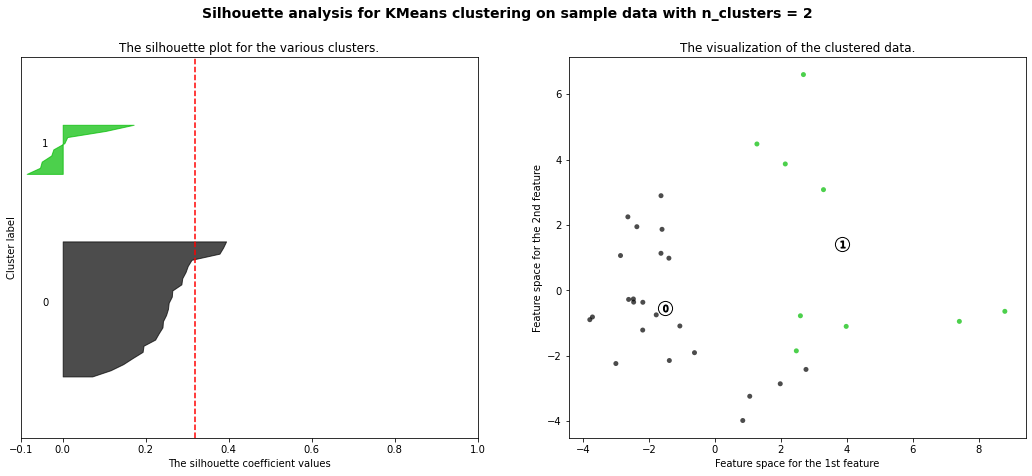

In [46]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


train_pca = list(X_train.reshape(X_train.shape[0], X_train.shape[1]))
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_pca)

X = train_pca

range_n_clusters = [2]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is : {:.2f}"
        .format(silhouette_avg),
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=100, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


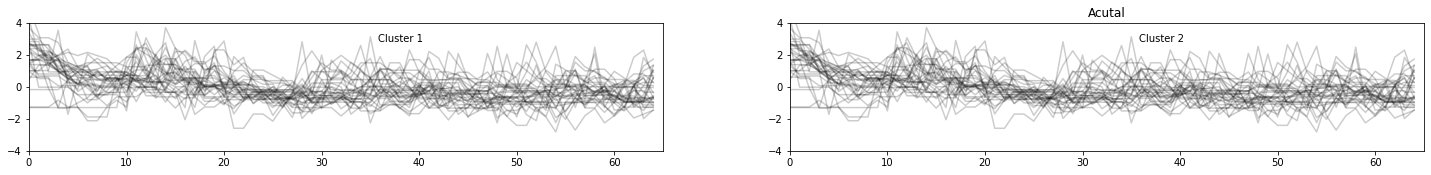

In [47]:
n_clusters = 2
sz = X_train.shape[1]
seed = 0

## Actual clusters(using labels) plot
plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X_train:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Acutal")

In [48]:
days = []
for i in days_idx:
    days.append(sleep_days[i])

# LABELLING

<ul>
    <li>1 means sleep after train </li>
    <li>0 means sleep in a rest day</li>
</ul>

In [49]:
for i in range(len(days)):
    print(i, days[i])

0 2022-08-04
1 2022-08-05
2 2022-08-06
3 2022-08-07
4 2022-08-08
5 2022-08-09
6 2022-08-10
7 2022-08-11
8 2022-08-12
9 2022-08-14
10 2022-08-16
11 2022-08-17
12 2022-08-18
13 2022-08-19
14 2022-08-20
15 2022-08-21
16 2022-08-22
17 2022-08-23
18 2022-08-24
19 2022-08-25
20 2022-08-26
21 2022-08-27
22 2022-08-28
23 2022-08-29
24 2022-08-30
25 2022-09-01
26 2022-09-02
27 2022-09-03
28 2022-09-04
29 2022-09-05
30 2022-09-06
31 2022-09-07


In [50]:
from sklearn.metrics import classification_report, accuracy_score, precision_score,recall_score, f1_score

def confusion_matrix_plot(y,pred1,pred2,title1, title2):
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    ax[0].set_title(title1)
    ax[1].set_title(title2)
    accuracy = np.round(accuracy_score(y,pred1), 2)
    precision = np.round(precision_score(y,pred1), 2)
    recall = np.round(recall_score(y,pred1), 2)
    f1_sco = np.round(f1_score(y,pred1), 2)

    ax[0].text(0.5, 2.5, 'Accuracy: {}\nPrecision: {}\nRecall: {}\nF1-score: {}'.format(accuracy,precision, recall, f1_sco), ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})


    accuracy = np.round(accuracy_score(y,pred2), 2)
    precision = np.round(precision_score(y,pred2), 2)
    recall = np.round(recall_score(y,pred2), 2)
    f1_sco = np.round(f1_score(y,pred2), 2)

    ax[1].text(0.5, 2.5, 'Accuracy: {}\nPrecision: {}\nRecall: {}\nF1-score: {}'.format(accuracy,precision, recall, f1_sco), ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})


    cm = confusion_matrix(y, pred1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax[0], cmap=plt.cm.Blues)

    cm = confusion_matrix(y, pred2)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax[1], cmap=plt.cm.Blues)
    plt.show()


In [51]:
y = np.zeros(len(days))
y[4] = 1   # 8 Agoust
y[5] = 1   # 9 August
y[6] = 1   # 10 August
y[8] = 1   # 12 August
y[11] = 1  # 17 Agoust
y[21] = 1  # 27 August
y[24] = 1  # 30 August
y[12] = 1  # 18 August
y[19] = 1  # 25 August
y[9] = 1   # 14 August
y[23] = 1  # 29 August
y[23] = 1  # 29 August
y[29] = 1  # 5 sep
y[31] = 1  # 7 sep

In [52]:
X_test = X_train[21:].copy()
X_train = X_train[:21].copy()

res_test = y[21:]
res_train = y[:21]

Euclidean k-means
Euclidean silhoutte: 0.16


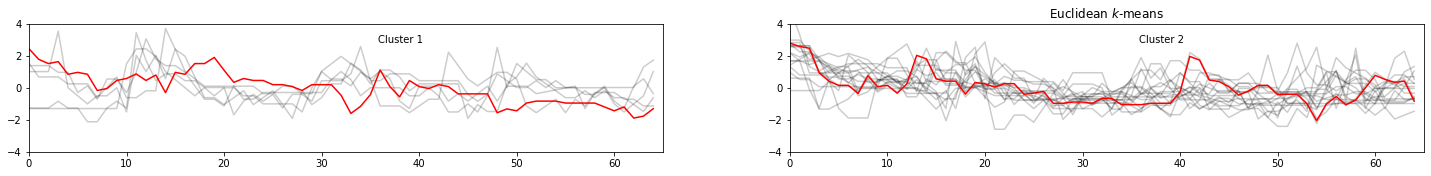

In [53]:
# Euclidean k-means
print("Euclidean k-means")
km_train = TimeSeriesKMeans(n_clusters=2, verbose=False, random_state=seed)
y_pred_km = km_train.fit_predict(X_train)


print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X_train, y_pred_km, metric="euclidean")))

plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X_train[y_pred_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

DBA k-means
DBA silhoutte: 0.18


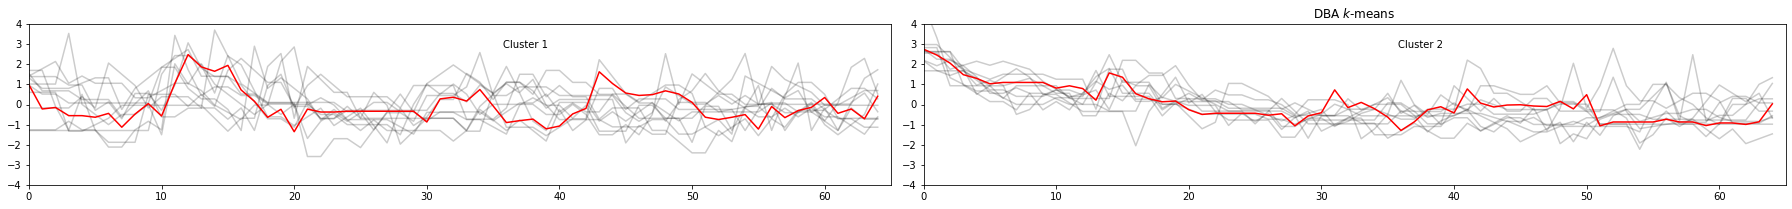

In [54]:
# DBA-k-means
print("DBA k-means")
dba_km_train = TimeSeriesKMeans(n_clusters=2,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred_dba_km_train = dba_km_train.fit_predict(X_train)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X_train, y_pred_dba_km_train, metric="dtw")))

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi+1)
    for xx in X_train[y_pred_dba_km_train == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km_train.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
        


plt.tight_layout()
plt.show()

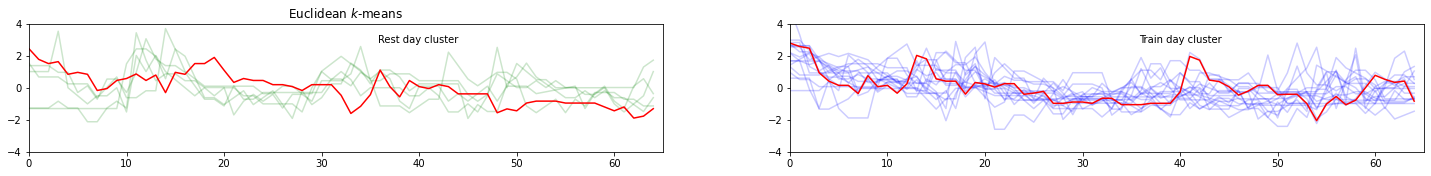

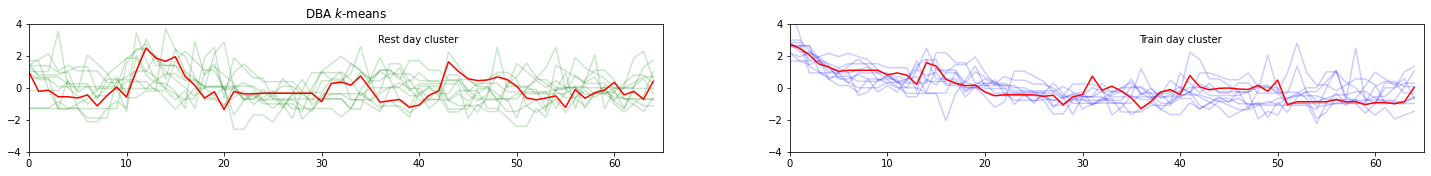

In [55]:
from sklearn import metrics

### Actual clusters(using labels) plot
#plt.figure()
#for yi in range(n_clusters):
#    plt.subplot(3, n_clusters, yi + 1)
#    for xx in X_train:
#        plt.plot(xx.ravel(), "k-", alpha=.2)
#    plt.xlim(0, sz)
#    plt.ylim(-4, 4)
#    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
#             transform=plt.gca().transAxes)
#    if yi == 1:
#        plt.title("Acutal")
    
clusters = ['Rest day cluster', 'Train day cluster']
colors = ['green', 'blue']
plt.figure()
for yi in range(n_clusters):
    plt.title("Euclidean $k$-means")

    plt.subplot(3, n_clusters, yi + 3)
    for xx in X_train[y_pred_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2, color=colors[yi])
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,clusters[yi],
             transform=plt.gca().transAxes)

plt.show()

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 5)
    for xx in X_train[y_pred_dba_km_train == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2, color=colors[yi])
    plt.plot(dba_km_train.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,clusters[yi],
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("DBA $k$-means")
plt.show()

silhoutte after PCA transformation: 0.16


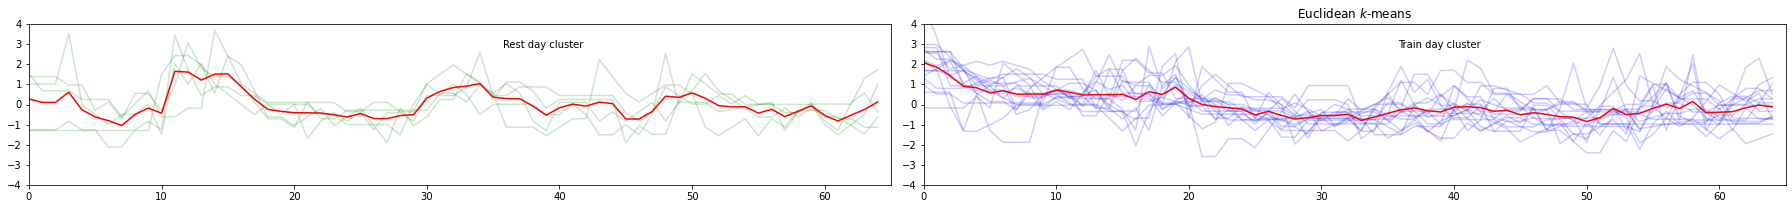

In [56]:
from sklearn.cluster import KMeans
import math

train_pca_train = list(X_train.reshape(X_train.shape[0], X_train.shape[1]))
pca = PCA(n_components=0.95)
train_pca = pca.fit_transform(train_pca_train)

# Euclidean k-means
km_PCA = TimeSeriesKMeans(n_clusters=2, verbose=False, random_state=seed)
y_pred_km_PCA = km_PCA.fit_predict(train_pca_train)


print("silhoutte after PCA transformation: {:.2f}".format(silhouette_score(X_train, y_pred_km_PCA, metric="euclidean")))

plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in X_train[y_pred_km_PCA == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2, color= colors[yi])
    plt.plot(km_PCA.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,clusters[yi],
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.tight_layout()
plt.show()

Euclidean silhoutte: 0.08
DBA k-means
DBA silhoutte: 0.06


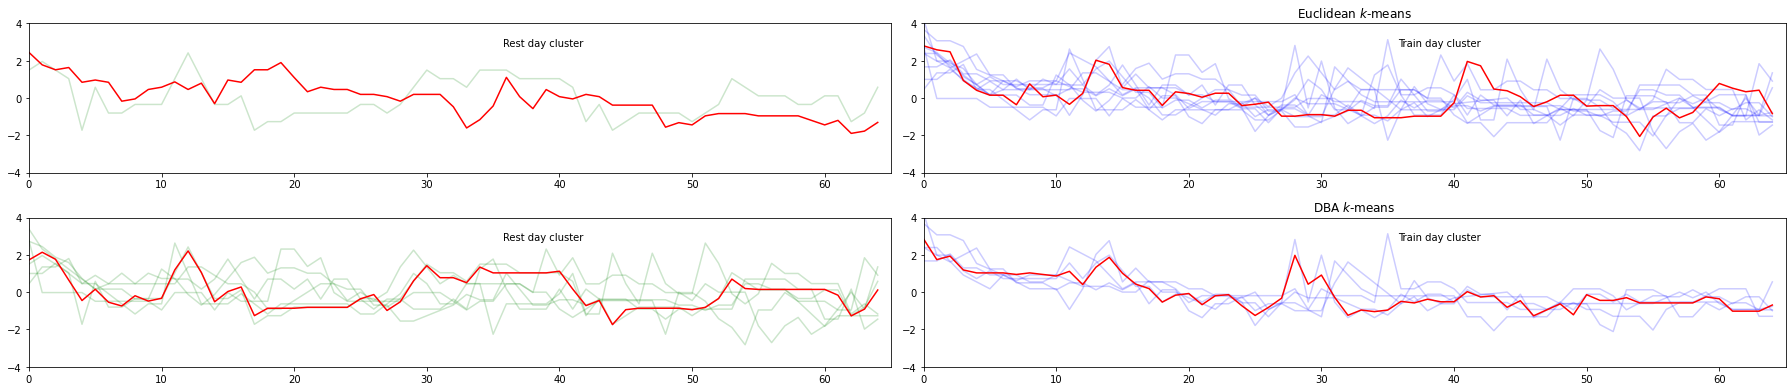

In [57]:
n_clusters = 2

y_pred_km_test = km_train.fit_predict(X_test)
print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X_test, y_pred_km_test, metric="euclidean")))

plt.figure()
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 3)
    for xx in X_test[y_pred_km_test == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2, color=colors[yi])
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,clusters[yi],
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

# DBA-k-means
print("DBA k-means")

y_pred_dba_km_test = dba_km_train.fit_predict(X_test)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X_test, y_pred_dba_km_test, metric="dtw")))

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 5)
    for xx in X_test[y_pred_dba_km_test == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2, color=colors[yi])
    plt.plot(dba_km_train.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,clusters[yi],
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
        


plt.tight_layout()
plt.show()

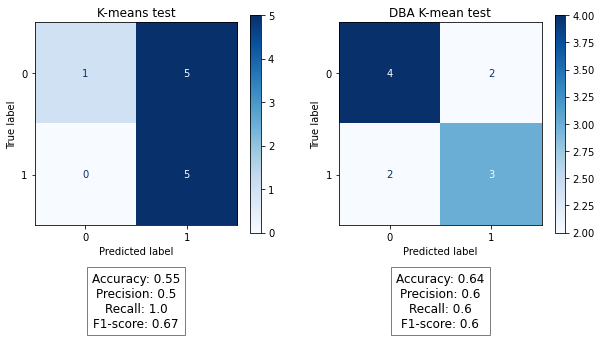

In [58]:
confusion_matrix_plot(res_test,y_pred_km_test, y_pred_dba_km_test,'K-means test', 'DBA K-mean test' )

In [59]:
score = 0
for i in range(len(res_test)):
    if(res_test[i] == y_pred_km_test[i]):
        score = score + 1
print('Score: {}/{}'.format(score,len(res_test)))

score = 0
for i in range(len(res_test)):
    if(res_test[i] == y_pred_dba_km_test[i]):
        score = score + 1
print('Score: {}/{}'.format(score,len(res_test)))

Score: 6/11
Score: 7/11


# HR

Text(0.5, 1.0, 'HR box plot')

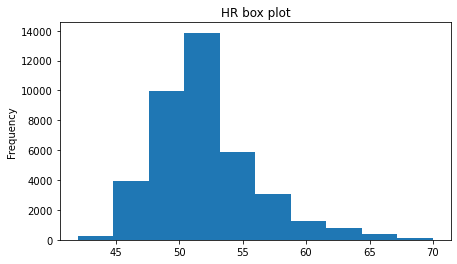

In [60]:
train_catene = []
rest_catene = []
i = 0
for dataset in datasets_input:
    if(y[i] == 1):
        train_catene = train_catene + datasets_input.ravel().tolist()
    else:
        rest_catene = rest_catene + datasets_input.ravel().tolist()
    i=i+1
ax = pd.DataFrame(rest_catene).plot(kind='hist', figsize=(7,4),legend=0)
ax.set_title('HR box plot')

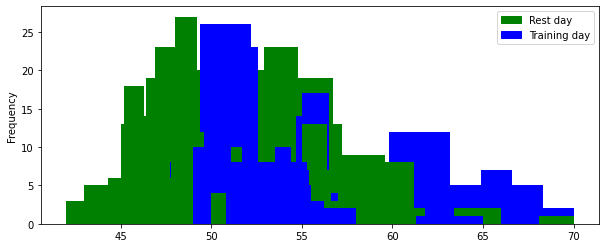

In [61]:
labels=['Rest day','Training day']
i = 0
color='green'
if(y[i] == 1):
    color = 'blue'
ax = pd.DataFrame(datasets_input[0]).plot(kind='hist', color=color, figsize=(10,4))

for dataset in datasets_input[1:]:
    i=i+1
    if(y[i] == 1):
        color = 'blue'
    else:
        color='green'
    pd.DataFrame(dataset).plot(kind='hist', ax=ax, color=color)

ax.legend(labels)
leg = ax.get_legend()
leg.legendHandles[0].set_color('green')
leg.legendHandles[1].set_color('blue')
plt.show()

Euclidean k-means
Euclidean silhoutte: 0.16
DBA k-means
DBA silhoutte: 0.18


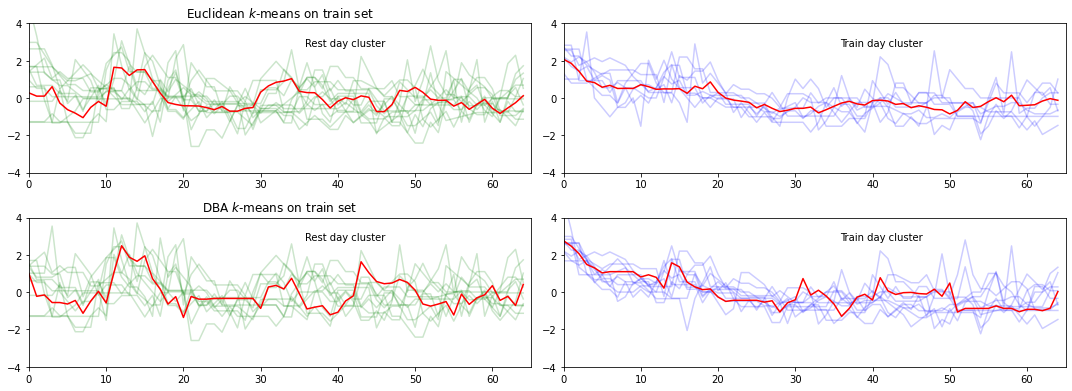

In [62]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
y_pred_km = km.fit_predict(X_train)


print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X_train, y_pred_km, metric="euclidean")))

plt.figure(figsize=(15,8))
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 3)
    for xx in X_train[res_train == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2, color=colors[yi])
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,clusters[yi],
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("Euclidean $k$-means on train set")
        
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred_dba_km = dba_km.fit_predict(X_train)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X_train, y_pred_dba_km, metric="dtw")))

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi+5)
    for xx in X_train[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2, color=colors[yi])
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,clusters[yi],
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("DBA $k$-means on train set")
        


plt.tight_layout()
plt.show()

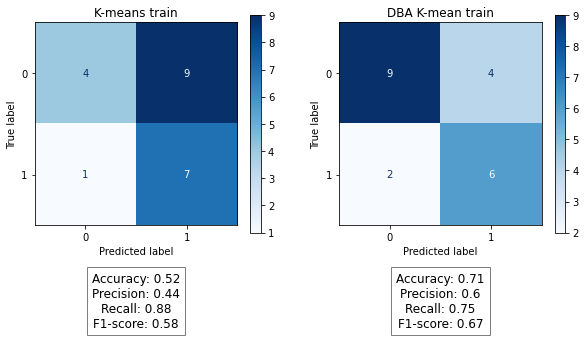

In [63]:
confusion_matrix_plot(res_train,y_pred_km, y_pred_dba_km,'K-means train', 'DBA K-mean train' )

Euclidean silhoutte: 0.12
DBA k-means
DBA silhoutte: 0.17


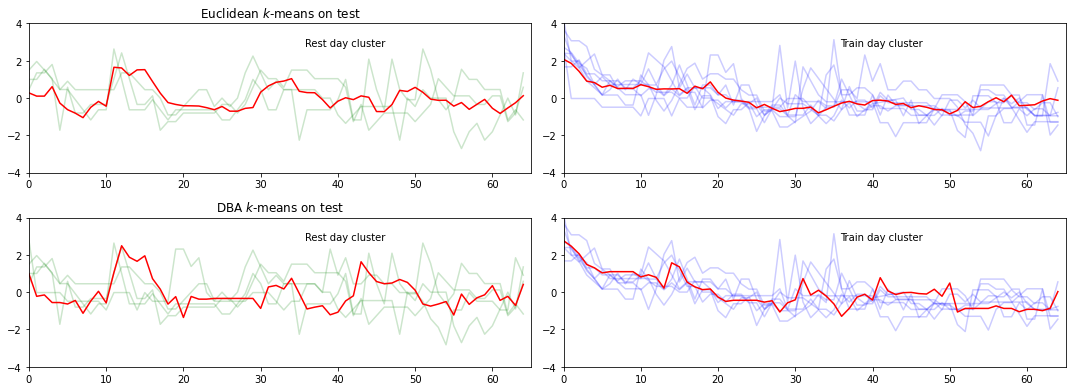

In [64]:
n_clusters = 2

y_pred_km_test = km.predict(X_test)
print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X_test, y_pred_km_test, metric="euclidean")))

plt.figure(figsize=(15,8))
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 3)
    for xx in X_test[y_pred_km_test == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2, color=colors[yi])
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,clusters[yi],
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("Euclidean $k$-means on test")

# DBA-k-means
print("DBA k-means")

y_pred_dba_km_test = dba_km.predict(X_test)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X_test, y_pred_dba_km_test, metric="dtw")))

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 5)
    for xx in X_test[y_pred_dba_km_test == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2, color=colors[yi])
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,clusters[yi],
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("DBA $k$-means on test")
        


plt.tight_layout()
plt.show()

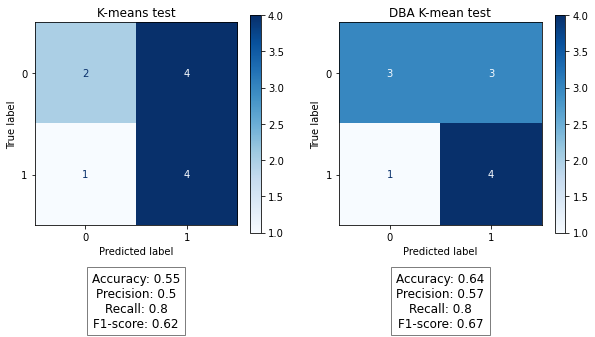

In [65]:
confusion_matrix_plot(res_test,y_pred_km_test, y_pred_dba_km_test,'K-means test', 'DBA K-mean test' )

# HRV 

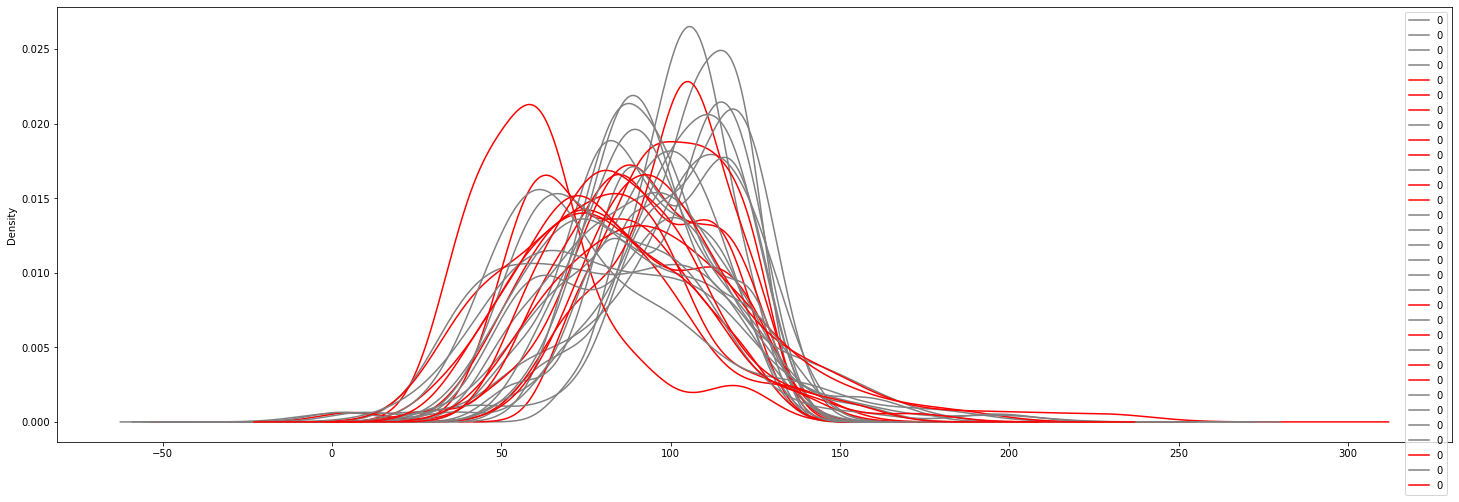

In [66]:
i = 0
color='grey'
if(y[i] == 1):
    color = 'red'
ax = pd.DataFrame(datasets_input_hrv[0]).plot(kind='kde', color=color)
for dataset in datasets_input_hrv[1:]:
    i=i+1
    if(y[i] == 1):
        color = 'red'
    else:
        color='grey'
    pd.DataFrame(dataset).plot(kind='kde', ax=ax, color=color)
plt.show()


In [67]:
X_test_hrv = X_train_hrv[21:].copy()
X_train_hrv = X_train_hrv[:21].copy()

res_test = y[21:]
res_train = y[:21]

Euclidean k-means
Euclidean silhoutte: 0.05
DBA k-means
DBA silhoutte: 0.08


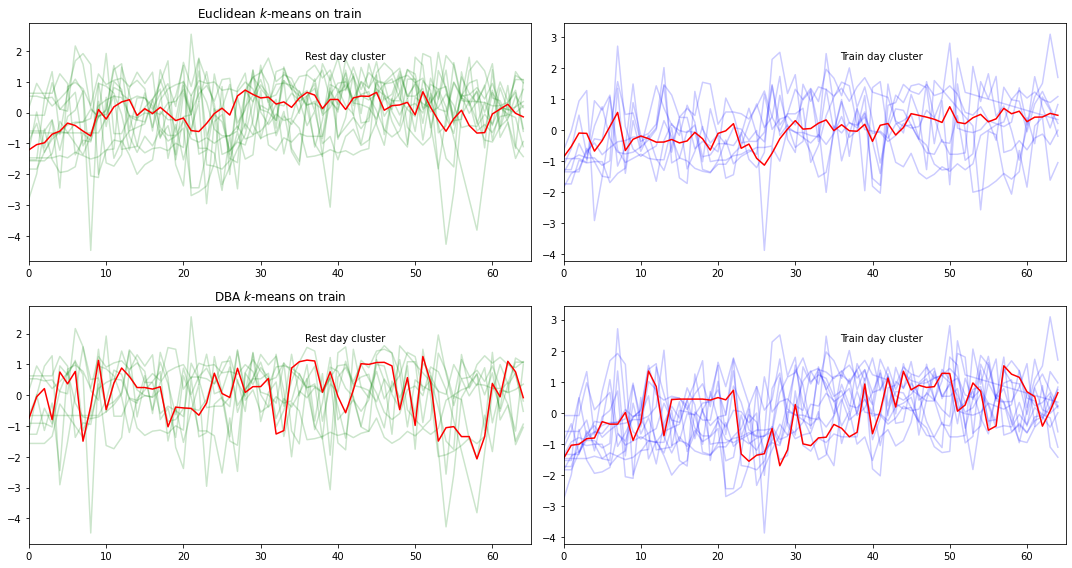

In [68]:
# Euclidean k-means
print("Euclidean k-means")
km_hrv = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=seed)
y_pred_km = km_hrv.fit_predict(X_train_hrv)


print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X_train_hrv, y_pred_km, metric="euclidean")))

plt.figure(figsize=(15,8))
for yi in range(n_clusters):
    plt.subplot(2, n_clusters, yi + 1)
    for xx in X_train_hrv[res_train == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2, color=colors[yi])
    plt.plot(km_hrv.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.text(0.55, 0.85,clusters[yi],
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("Euclidean $k$-means on train")
        
print("DBA k-means")
dba_km_hrv = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred_dba_km = dba_km_hrv.fit_predict(X_train_hrv)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X_train_hrv, y_pred_dba_km, metric="dtw")))

for yi in range(n_clusters):
    plt.subplot(2, n_clusters, yi+3)
    for xx in X_train_hrv[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2, color=colors[yi])
    plt.plot(dba_km_hrv.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.text(0.55, 0.85,clusters[yi],
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("DBA $k$-means on train")
        


plt.tight_layout()
plt.show()
        

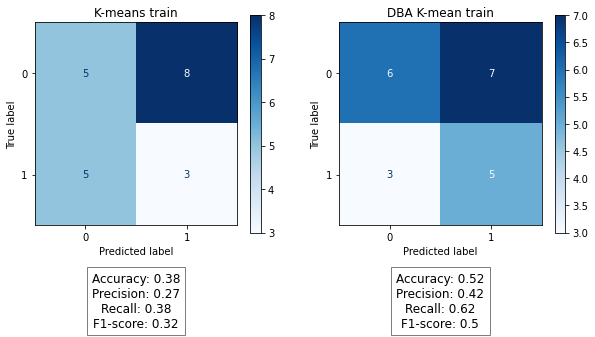

In [69]:
confusion_matrix_plot(res_train,y_pred_km, y_pred_dba_km,'K-means train', 'DBA K-mean train' )

Euclidean silhoutte: 0.00
DBA k-means
DBA silhoutte: 0.02


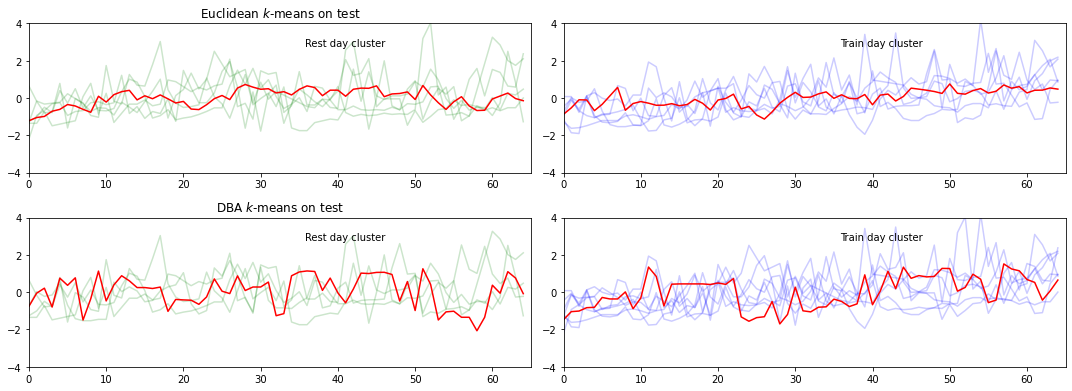

In [72]:
##### n_clusters = 2

y_pred_km_test = km_hrv.predict(X_test_hrv)
print("Euclidean silhoutte: {:.2f}".format(silhouette_score(X_test_hrv, y_pred_km_test, metric="euclidean")))

plt.figure(figsize=(15,8))
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 3)
    for xx in X_test_hrv[y_pred_km_test == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2, color=colors[yi])
    plt.plot(km_hrv.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,clusters[yi],
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("Euclidean $k$-means on test")

# DBA-k-means
print("DBA k-means")

y_pred_dba_km_test = dba_km_hrv.predict(X_test_hrv)
print("DBA silhoutte: {:.2f}".format(silhouette_score(X_test_hrv, y_pred_dba_km_test, metric="dtw")))

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 5)
    for xx in X_test_hrv[y_pred_dba_km_test == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2, color=colors[yi])
    plt.plot(dba_km_hrv.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,clusters[yi],
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("DBA $k$-means on test")
        


plt.tight_layout()
plt.show()

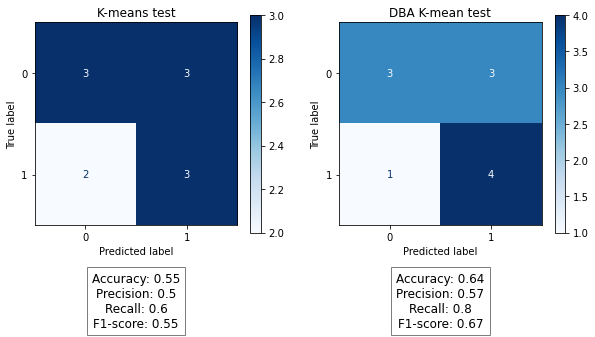

In [73]:
confusion_matrix_plot(res_test,y_pred_km_test, y_pred_dba_km_test,'K-means test', 'DBA K-mean test' )

In [ ]:
hrv_df = []
for hrv in hrv_list:
    hrv_df.append(np.array(hrv).ravel().tolist())

In [ ]:
pd.set_option('display.max_columns', None)
new_df = df[['hr_5min']][0:len(days_idx)].copy()
new_df['hr_mean'] = 0


new_df['hrv_mean'] = 0

#new_df['target'] = 0

idx = 0
for i in days_idx:
    new_df['hr_mean'][idx] = np.round(np.mean(df['hr_5min'][i]),2)
    new_df['hrv_mean'][idx] = df['rmssd'][i]

    idx = idx + 1

#for i in range(len(new_df)):
#    new_df['target'][i] = y[i]

In [ ]:
new_df.drop('hr_5min', axis=1,inplace=True)

In [ ]:
df

In [ ]:
new_df

In [ ]:
# example of training a final classification model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
# fit final model
model = LogisticRegression(max_iter=10000)
poly_var_train, poly_var_test, res_train, res_test = train_test_split(new_df, y, test_size = 0.3)
model.fit(poly_var_train, res_train)

# make a prediction
ynew = model.predict(poly_var_test)
ynew_prob = model.predict_proba(poly_var_test)

# show the inputs and predicted outputs
point = 0
for i in range(len(poly_var_test)):
    if(res_test[i]== ynew[i]):
        point = point + 1
    print("Real class={}, Predicted={} {}".format(res_test[i], ynew[i], ynew_prob[i]))
print('{} over {}'.format(point, len(poly_var_test)))